# Data preparation for DFW, TX

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import rcParams  
# from collections import Set
import time
import fiona
# import simplify
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pickle
import glob
from itertools import compress
import ctypes
import multiprocessing as mp
#from multiprocessing import Pool, cpu_count, TimeoutError, Value, Array

import csv

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

import os

# matlab io
import scipy.io as sio
from scipy.sparse import csr_matrix

%matplotlib inline
rcParams['figure.figsize'] = (10, 10) #Size of figure  
rcParams['figure.dpi'] = 125

# Parameters

## Road network parameters

In [2]:
# Number of clusters to discretize the road network
nclusters = 25

# Power Network Parameters

In [3]:
# The cost of the power network can be selected in three possible ways.
# - 'discounted' considers a cost that accounts for construction costs as
#    well as operational costs.
#    source EIA, “Levelized cost and levelized avoided cost of new
#       generation resources in the annual energy outlook 2017,”
#       U.S. Energy Information Administration, Tech. Rep., 2017.
# - 'operational_2010' considers only the operational costs of the power
#   cost in 2010. 
#   Source EIA: Table 8.4. Average Power Plant Operating Expenses for
#      Major U.S. Investor-Owned Electric Utilities, 2006 through 2016
#     (Mills per Kilowatthour)
#     https://www.eia.gov/electricity/annual/html/epa_08_04.html
# - 'operational_2016' considers the operational cost in 2016. 
power_cost_type = 'operational_2016'


# These parameters allow us to play with what-if scenarios
# related to renewable penetration in the electric power network

# The amount of power produced by renewable energy sources
# is multiplied by the parameter RenewableBoost to simulate
# increased penetration of renewables
RenewableBoost = 1

# If the flag AdditionalSolar is set to True, additional solar
# panels are added to all roofs across Texas (unless LocalSolarOnly
# is set, see below.)
AdditionalSolar = False

# If both the flag AdditionalSolar and the flag LocalSolarOnly are
# set to True, additional solar panels are added only to roof within
# the Dallas-Fort Worth metroplex
LocalSolarOnly = False

# The amount of solar installed on each rooftop is set by MW_per_roof
# This is the average amount of power across an entire day. The time
# distribution is computed according to ERCOT data deep in the notebook.
MW_per_roof = 0.005  # 5 kw

## Electric vehicle parameters

In [4]:
# Number of battery discretization steps
C = 30
# Battery size of a Chevy Bolt, in kWh
battery_size = 60.
# Range of a Chevy Bolt, in m
vehicle_range = 383000.

# Minimum charge at the end of the scenario
min_end_charge=round(C/2.)

# Vehicle-to-grid efficiency
v2g_efficiency=0.9

# Charger speed. L2 charger, nothing crazy.
charge_speed_per_hour = 20.  # charger speed in KW

# Battery depreciation
# A Chevy Bolt's battery costs 15734.29 dollars. LiPos last on average 1000 cycles.
# Each cycle is made of C charge steps.
# Also, we consider both charging and discharging.
BatteryCost = 15734.29
BatteryCycles = 1000. #More than 500, but not much more

## Time discretization parameters

In [5]:
# Size of the discretization time step
stepsize = 30 * 60 # 30 minutes in seconds

# Number of hours to consider in the simulation
nhours = 12

# Start hour for the simulation
StartHour = 5;

# Last hour when passengers depart.
# It is often of interest to truncate the passenger distribution,
#  so as to allow everyone to make it home by the end of the somulation
EndHourPax = 15;

# Number of vehicles. For best results, this should be a bit more than
# 1/3 the number of passengers (see Singapore case study)
num_vehicles = 4.5*1e5; #Number of vehicles

# If this is set, customers are set to return home a few hours after they
# commute to work. Useful for 24-hour simulations
add_return_trips = False

# If add_return_trips is set, passengers going from location i to location
# j at time t will return home after t+workdayduration hours.
workdayduration = 8. #hours

# Auto-computed number of time steps
ntimesteps = int(nhours * 3600 / stepsize) # n hours in terms of timesteps

## Cost parameters

In [6]:
# Value of time per hour.
# From https://www.transportation.gov/sites/dot.gov/files/docs/Revised%20Departmental%20Guidance%20on%20Valuation%20of%20Travel%20Time%20in%20Economic%20Analysis.pdf 
value_of_time_per_hr=24.4 

# NOT USED: Vehicle cost per km.
# From https://www.rita.dot.gov/bts/sites/rita.dot.gov.bts/files/publications/national_transportation_statistics/html/table_03_17.html
OLD_vehicle_cost_per_km=0.486/1.6

# New lower costs from AAA.
# https://newsroom.aaa.com/tag/driving-cost-per-mile/
vehicle_cost_per_km=0.1601/1.6

# Auto-computed value of time per discrete time step
value_of_time=value_of_time_per_hr*stepsize/3600.

## Miscellaneous parameters

In [7]:
# Plotting tools sprinkled through the notebook
plot_flag = True

# Compute the distance between clusters in parallel with threading.
# I found this to be very unstable/buggy, so I normally keep this off and run the process once, overnight.
parallelflag=True

## Temporary files

In [8]:
data_dir = 'Data/'

road_data_dir = data_dir+'road_network/'

power_data_dir = data_dir+'power_network/'

figure_data_dir = data_dir+'fig/'

emissions_data_dir = data_dir+'emissions/'

commute_data_dir = data_dir+'commuting_data/'

scenario_dir = 'scenario/'

# Download data for all of DFW

In [9]:
if os.path.exists(road_data_dir+'DFWMap.pkl') and os.path.exists(road_data_dir+'DFWCounties.pkl'):
    downloadflag=False
    try:
        print("Reading cached OSM map for several Texas counties.")
        inputm = open(road_data_dir+'DFWMap.pkl', 'rb')
        G=pickle.load(inputm)
        inputm.close()
        inputc = open(road_data_dir+'DFWCounties.pkl', 'rb')
        ctboundaries=pickle.load(inputc)
        inputc.close()
    except:
        print("Reading map failed! Will re-download")
        # If anything goes wrong with the pickled inputs, re-download them
        downloadflag=True
else:
    downloadflag = True

if downloadflag:
    # THIS MIGHT TAKE TIME
    # The code below is VERY fragile: graph_from_place relies on calls
    #   to the OSM Nominatim API (https://nominatim.openstreetmap.org),
    #   which may give unexpected results. If you get an error of type
    #   'Geometry must be a shapely Polygon or MultiPolygon', check what
    #   Nominatim is returning first.

    places = ['Collin County, Texas',
    'Dallas County, Texas',
    'Denton County, Texas',
    'Ellis County, Texas',
    'Hood County, Texas',
    'Hunt County, Texas',
    'Johnson County, Texas',
    'Kaufman County, Texas, United States of America',
    'Parker County, Texas',
    'Rockwall County, Texas',
    'Somervell County, Texas',
    'Tarrant County, Texas, United States of America',
    'Wise County, Texas']
    # County FIPS: [085,113,121,139,221,231,251,257,367,397,425,439,497]
    
    print("Downloading OSM data for several Texas counties. This may take a while")
    G = ox.graph_from_place(places, network_type='drive')
    print("Done downloading, now creating county boundaries")
    ctboundaries=[]
    for ct in places:
        ctboundaries.append(ox.gdf_from_place(ct))
    ctboundaries=gpd.GeoDataFrame( pd.concat( ctboundaries, ignore_index=True) )
    print("Caching NetworkX representation to speed up future executions")
    #Pickle road graph
    output = open(road_data_dir+'DFWMap.pkl', 'wb')
    pickle.dump(G, output)
    output.close()
    # Pickle counties
    outputc = open(road_data_dir+'DFWCounties.pkl', 'wb')
    pickle.dump(ctboundaries, outputc)
    outputc.close()

Reading cached OSM map for several Texas counties.


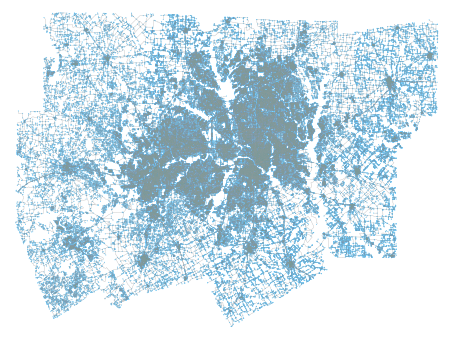

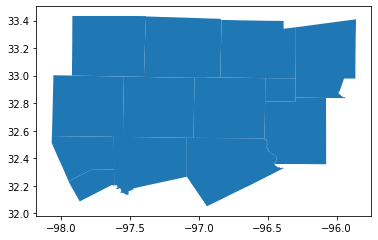

In [10]:
ox.plot_graph(G,node_size=1,edge_linewidth=0.25,edge_alpha=0.5)
ctboundaries.plot()

# Run K-Means on the Centroids

In [11]:
# These were downloaded from USGS and centroids were computed in QGIS.
# It's sometimes easier to go out-of-band, I think.
census_tracts = {}
with fiona.open(road_data_dir+'DFW_tract_centroids/DFW_tract_centroids.shp') as c:
    for f in c:
        tractid = f['properties']['GEO_ID']
        #if name in ignored_names: continue
        centroid = f['geometry']['coordinates']
        name2 = f['properties']['TRACT']
        fullname = f['properties']['STATE']+f['properties']['COUNTY']+f['properties']['TRACT']
        if tractid in census_tracts.keys():
            print(tractid)
        census_tracts[tractid] = {}
        census_tracts[tractid]['centroid'] = centroid
        census_tracts[tractid]['name2'] = int(name2)
        census_tracts[tractid]['name'] = int(fullname)

In [12]:
centroids = np.array([tract['centroid'] for key,tract in census_tracts.items()])

In [13]:
kmeans = KMeans(n_clusters=nclusters, random_state=20170116).fit(centroids)

In [14]:
i=0
for name, tract in census_tracts.items():
    tract['cluster'] = kmeans.labels_[i]
    i+=1

In [15]:
with open(road_data_dir+'DFW_tract_centroids/DFW_tract_centroid_{}cl_labels.csv'.format(nclusters), 'w') as csv_clusters:
    writer = csv.writer(csv_clusters)
    writer.writerow(["GEO_ID", "cluster"])
    for key, value in census_tracts.items():
        writer.writerow([key, value['cluster']])

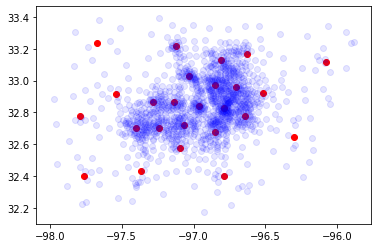

In [16]:
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], color = 'red')
plt.scatter(centroids[:,0],centroids[:,1], color = 'blue', alpha=0.1)

# For each cluster, assign a node


In [17]:
node_coords_with_index = np.array([ [[ G.nodes[n]['x'], G.nodes[n]['y']],n] for n in G.nodes()])
node_coords,node_coord_idx = zip(*node_coords_with_index)
node_coord_idx=np.array(node_coord_idx)


In [18]:
nbrs = NearestNeighbors(n_neighbors=1).fit(node_coords)

In [19]:
distances, indices = nbrs.kneighbors(kmeans.cluster_centers_)

In [20]:
clusters = {}
for i,cluster in enumerate(kmeans.cluster_centers_):
    clusters[i] = {}
    clusters[i]['node'] = list(G.nodes())[indices[i][0]]
    clusters[i]['centroid'] = cluster

In [21]:
# and let's store the center of dfw
center_coord = [-97.0403352, 32.8998091]
distances, indices = nbrs.kneighbors(np.array([center_coord]))
center_node = list(G.nodes())[indices[0][0]]

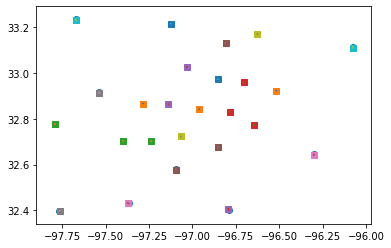

In [22]:
# Plot the result
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker = 'o')
for i, cl in clusters.items():
    plt.scatter(G.nodes[cl['node']]['x'],G.nodes[cl['node']]['y'],marker = 's')
    plt.plot([G.nodes[cl['node']]['x'], clusters[i]['centroid'][0]],[G.nodes[cl['node']]['y'],clusters[i]['centroid'][1]])

# For each road assign maxspeed and travel time

In [23]:
# # Somewhat arbitrary. Speeds in kph

# maxspeeds = {u'corridor': 110,
#  u'emergency_access_point': 20,
#  u'living_street': 20,
#  u'living_street_tertiary': 20,
#  u'motorway': 110,
#  u'motorway_link': 110,
#  u'motorway_link_secondary': 110,
#  u'motorway_link_tertiary': 110,
#  u'motorway_link_trunk_link': 110,
#  u'motorway_link_trunk': 110,
#  u'motorway_motorway_link': 110,
#  u'motorway_primary': 110,
#  u'motorway_secondary': 110,
#  u'motorway_trunk': 110,
#  u'primary': 90,
#  u'primary_link': 90,
#  u'primary_link_primary': 90,
#  u'primary_motorway_link': 90,
#  u'primary_secondary': 90,
#  u'primary_trunk': 90,
#  u'primary_link_secondary': 90,
#  u'primary_tertiary': 50,
#  u'primary_link_residential': 50,
#  u'primary_trunk_link': 90,
#  u'primary_link_tertiary': 50,
#  u'residential': 50,
#  u'residential_link': 50,
#  u'residential_living_street': 50,
#  u'residential_road': 50,
#  u'residential_secondary': 50,
#  u'residential_tertiary': 50,
#  u'residential_trunk_link': 50,
#  u'residential_trunk': 50,
#  u'residential_primary': 50,
#  u'residential_primary_link': 50,
#  u'residential_secondary_link': 50,
#  u'residential_unclassified': 50,
#  u'road': 50,
#  u'secondary': 70,
#  u'sec': 70,
#  u'secondary_link': 70,
#  u'secondary_link_secondary': 70,
#  u'secondary_secondary_link': 70,
#  u'secondary_trunk_link': 70,
#  u'secondary_trunk': 70,
#  u'secondary_link_motorway_link_secondary':70,
#  u'secondary_link_tertiary_motorway_link_secondary': 50,
#  u'motorway_link_secondary_link': 50,
#  u'secondary_primary_link': 70,
#  u'secondary_primary': 70,
#  u'secondary_link_tertiary': 50,
#  u'tertiary': 50,
#  u'ser': 50,
#  u'tertiary_link': 50,
#  u'tertiary_link_tertiary': 50,
#  u'tertiary_motorway_link': 50,
#  u'tertiary_secondary': 50,
#  u'tertiary_secondary_link': 50,
#  u'tertiary_link_secondary': 50,
#  u'tertiary_trunk_link': 50,
#  u'tertiary_trunk': 50,
#  u'tertiary_unclassified': 50,
#  u'trunk': 110,
#  u'trunk_link': 110,
#  u'trunk_link_secondary': 70,
#  u'trunk_link_trunk': 70,
#  u'trunk_trunk_link': 70,
#  u'trunk_primary': 90,
#  u'trunk_secondary': 70,
#  u'unclassified': 50,
#  u'unclassified_residential': 50,
#  u'unclassified_residential_secondary': 50,
#  u'unclassified_residential_tertiary': 50,
#  u'unclassified_secondary': 50,
#  u'unclassified_tertiary': 50,
#  u'unclassified_living_street': 50,
#  u'unclassified_residential_trunk':50,
#  u'unclassified_trunk_link': 50,
#  u'unclassified_primary': 50,
#  u'uns': 50,
#  u'turning_circle': 30,
#  u'Schoolhouse Road': 25,
#  u'dismantled': 0.001,
#  u'razed' : 0.001,
#  u'planned_tertiary': 0.001,
#  u'crossing': 0.001,
#  u'residential_planned_tertiary': 0.001,
#  u'rebuilt': 0.001,
#  u'realligned': 0.001,
#             }

def road_speed(road_name):
    if ("realligned" in road_name or
        "planned" in road_name or
        "crossing" in road_name or
        "razed" in road_name or
        "dismantled" in road_name or
        "rebuilt" in road_name or
        "emergency_access_point" in road_name):
        return 0.001
    if ("living_street" in road_name):
        return 20.
    if ("turning_circle" in road_name or
       "roundabout" in road_name):
        return 30.
    if ("unclassified" in road_name or
        "uns" in road_name or
        "road" in road_name or
        "residential" in road_name):
        return 50.
    if "tertiary" in road_name:
        return 50.
    if ("secondary" in road_name or
        "sec" in road_name):
        return 70.
    if ("primary" in road_name):
        return 90.
    if ("trunk" in road_name or 
        "corridor" in road_name):
        return 110.
    if ("motorway" in road_name):
        return 110.
    print(road_name)
    return None

In [24]:
# Capacity is computed as Speed*VEhicleDensity*NumLanes
# VehicleDensity is 1km/VehicleEquivalentLength
# VehicleEquivalentLength is 4m + 3s of distance = 4m +SpeedLimit*3.6*3

#Diagnostics
# highway_types=set()
# for s,t,k in G.edges(keys=True):
#     highway_type = G[s][t][k]['highway']
#     if type(highway_type) is list:
#         highway_type = '_'.join(highway_type)
#     highway_types.add(highway_type)
    
# for highway_type in highway_types:
#     if highway_type not in maxspeeds.keys():
#         print(highway_type)

for s,t,k in G.edges(keys=True):
    highway_type = G[s][t][k]['highway']
    if type(highway_type) is list:
        highway_type = '_'.join(highway_type)
    #if highway_type == u'dismantled' or highway_type == u'planned_tertiary':
        #print G[s][t][k]
        #continue
    
    #G[s][t][k]['maxspeed'] = maxspeeds[highway_type]
    G[s][t][k]['maxspeed'] = road_speed(highway_type)
    G[s][t][k]['traveltime'] = G[s][t][k]['length'] / (G[s][t][k]['maxspeed'] * 0.2778) # in seconds
    if not 'lanes' in G[s][t][k]:
        G[s][t][k]['lanes']=1
    if type(G[s][t][k]['lanes'])==list:
        try:
            TempLanes=min(map(float,G[s][t][k]['lanes']))
        except:
            try: #It could be a list of strings...
                newstr=[]
                for i in range(len(G[s][t][k]['lanes'])):
                    mystrtmp=G[s][t][k]['lanes'][i].split(';')
                    newstr=newstr+mystrtmp
                TempLanes=min(map(float,newstr))
            except:
                import pdb; pdb.set_trace()
                print(G[s][t][k]['lanes'])
                print(s, t, k, " (list): without trying, we set numlanes=2")
                TempLanes=2
    elif type(G[s][t][k]['lanes'])==str:
        try:
            TempLanes=min(map(float,G[s][t][k]['lanes'].split(';')))
        except:
            print(G[s][t][k]['lanes'])
            print(s, t, k, " (unicode): without trying, we set numlanes=2")
            TempLanes=2
    else:
        try:
            TempLanes=float(G[s][t][k]['lanes'])
        except:
            print(G[s][t][k]['lanes'])
            print(type(G[s][t][k]['lanes']))
            print(s, t, k, " (not list): without trying, we set numlanes=2")
            TempLanes=2
    TempDensity=1000.0/(4+G[s][t][k]['maxspeed']/3.6*3.0) #See above: 4m + 3s distance
    G[s][t][k]['capacity']=float(TempLanes)*float(G[s][t][k]['maxspeed'])*TempDensity
    penalize = 0.5 * int(highway_type not in ['motorway', 'primary']) # overpenalize
    G[s][t][k]['weight'] = G[s][t][k]['traveltime'] / (1 - penalize)

w
5341564800 7593244320 0  (unicode): without trying, we set numlanes=2
w
7593244320 5341564800 0  (unicode): without trying, we set numlanes=2
w
7593244320 7593244347 0  (unicode): without trying, we set numlanes=2
w
7593244326 7593244347 0  (unicode): without trying, we set numlanes=2
w
7593244347 7593244320 0  (unicode): without trying, we set numlanes=2
w
7593244347 7593244326 0  (unicode): without trying, we set numlanes=2


# Reduce graph by removing multiple routes between two nodes

In [25]:
H = nx.DiGraph()
for s,t,k in G.edges(keys=True):
    if H.has_edge(s,t):
        if G[s][t][k]['traveltime'] < H[s][t]['traveltime']:
            H[s][t].update(G[s][t][k])
            H[s][t]['keep'] = False # to be used later
    else:
        H.add_edge(s,t)
        H[s][t].update(G[s][t][k])
        H[s][t]['keep'] = False # to be used later
        H.nodes[s].update(G.nodes[s])
        H.nodes[t].update(G.nodes[t])


# Label nodes in H according to nearest cluster

In [26]:
Tractnbrs = NearestNeighbors(n_neighbors=1).fit(kmeans.cluster_centers_)
distances, indices = Tractnbrs.kneighbors(node_coords)

i=0;
for nodeID, node in H.nodes.items():
    node['cluster']=indices[np.where(node_coord_idx==nodeID)[0][0]][0]
    i+=1

In [27]:
# Go through edges and label according to first and second cluster
for edgeid, edgedata in H.edges.items():
    firstedgeID = edgeid[0]
    secondedgeID = edgeid[1]
    StartClusterID=H.nodes[firstedgeID]['cluster']
    EndClusterID=H.nodes[secondedgeID]['cluster']
    edgedata['StartClusterID']=StartClusterID
    edgedata['EndClusterID']=EndClusterID

# For each pair of clusters, keep the relevant subgraph (SLOW)

In [28]:
# If a cached solution exists, use it!
if (os.path.exists(road_data_dir+'DFWCWlusterConnectivity'+str(nclusters)+'_v2.pkl') and
        os.path.exists(road_data_dir+'DFWCWlusterTravelTime'+str(nclusters)+'_v2.pkl') and
        os.path.exists(road_data_dir+'DFWCWlusterShortestPath'+str(nclusters)+'_v2.pkl') and
        os.path.exists(road_data_dir+'DFWCWlusterCapacity'+str(nclusters)+'_v2.pkl')
       ):
    computedistflag = False
    print("Cached map connectivity data exists")
else:
    computedistflag = True
    print("Map connectivity data missing - will recompute")

Cached map connectivity data exists


In [29]:
# This will take a long while

def find_cluster_connectivity(Inputs):
    FirstCluster = Inputs[0]
    SecondCluster = Inputs[1]
    #StartIndicesP = Inputs[2]
    #EndIndicesP = Inputs[3]
    StartIndices=np.frombuffer(StartIndicesP,dtype=ctypes.c_int)
    EndIndices=np.frombuffer(EndIndicesP,dtype=ctypes.c_int)
    
    #print StartIndices==FirstCluster
    return [FirstCluster, SecondCluster, sum(np.logical_and(StartIndices==FirstCluster,  EndIndices==SecondCluster))>0]

if computedistflag:

    print('Starting parallel computation of road capacities and travel times')

    SEIndices = [np.array([H[_start][_end]['StartClusterID'], H[_start][_end]['EndClusterID']]) for (_start, _end) in H.edges()]
    StartIndices, EndIndices = zip(*SEIndices)
    StartIndices = np.array(StartIndices)
    EndIndices = np.array(EndIndices)

    StartIndicesP = mp.RawArray(ctypes.c_int,StartIndices)
    EndIndicesP  =  mp.RawArray(ctypes.c_int,EndIndices)
    print('Checking which clusters are connected...')
    # Here we find out which pairs of clusters are connected.
    poolBool = mp.Pool(processes=mp.cpu_count()-2)
    poolBooloutput = poolBool.map(find_cluster_connectivity,([FirstCluster, SecondCluster] for FirstCluster in range(nclusters) for SecondCluster in range(FirstCluster+1,nclusters)))
    poolBool.terminate()
    # and we unpack the output
    pboct=len(poolBooloutput)
    ValidStartIndices=[]
    ValidEndIndices=[]
    for ct in range(pboct):
        [FC,SC,Connected] = poolBooloutput[ct]
        if Connected:
            ValidStartIndices.append(FC)
            ValidEndIndices.append(SC)
    ValidClusters=list(zip(ValidStartIndices,ValidEndIndices))


    output0 = open(road_data_dir+'DFWCWlusterConnectivity'+str(nclusters)+'_v2.pkl', 'wb')
    pickle.dump(list(ValidClusters), output0)
    output0.close()

In [30]:
def ComputeClusterConnectivity(Inputs):
    
    FirstCluster=Inputs[0]
    SecondCluster=Inputs[1]
    #H=Inputs[2]
    #G=Inputs[3]
    #clusters=Inputs[4]
    print('Clusters: '+str(FirstCluster)+'-'+str(SecondCluster))

    connedgectA=0
    connedgectB=0
    for EdgeID in H.edges():
        edgeSCl=H[EdgeID[0]][EdgeID[1]]['StartClusterID']
        edgeECl=H[EdgeID[0]][EdgeID[1]]['EndClusterID']
        if ((edgeSCl==FirstCluster) and (edgeECl==SecondCluster)):
            connedgectA+=1
        if ((edgeSCl==SecondCluster) and (edgeECl==FirstCluster)):
            connedgectB+=1

    #print connedgectA, connedgectB

    if connedgectA>0 and connedgectB>0:

        Hc=H.copy()
        #Gc=G.copy()
        for EdgeID in list(Hc.edges()):
            edgeSCl=Hc[EdgeID[0]][EdgeID[1]]['StartClusterID']
            edgeECl=Hc[EdgeID[0]][EdgeID[1]]['EndClusterID']
            if not ((edgeSCl==FirstCluster or edgeSCl==SecondCluster) and (edgeECl==FirstCluster or edgeECl==SecondCluster)):
                Hc.remove_edge(EdgeID[0],EdgeID[1])
            #        Gc.remove_edge(EdgeID[0],EdgeID[1])
            #for nodeID, node in Hc.node.iteritems():
            #    if not (node['cluster']==FirstCluster or node['cluster']==SecondCluster):
            #        Gc.remove_node(nodeID)


            #ox.plot_graph(Gc)

        StartProbeNode=clusters[FirstCluster]['node']
        EndProbeNode=clusters[SecondCluster]['node']
        try:
            #print 'Shortest path'
            CClusterTravelTime1=nx.shortest_path_length(Hc,source=StartProbeNode,target=EndProbeNode,weight='weight')
            CClusterShortestPath1=nx.shortest_path(Hc,source=StartProbeNode,target=EndProbeNode,weight='weight')
            #print 'Capacity'
            CClusterCapacity1=nx.maximum_flow_value(Hc,StartProbeNode,EndProbeNode,capacity='capacity')
        except:
            CClusterTravelTime1=np.infty
            CClusterShortestPath1=None
            CClusterCapacity1=np.infty
            print('Clusters '+str(FirstCluster)+' and '+str(SecondCluster)+' are not connected')
        try:
            CClusterTravelTime2=nx.shortest_path_length(H,source=EndProbeNode,target=StartProbeNode,weight='weight')
            CClusterShortestPath2=nx.shortest_path(Hc,source=EndProbeNode,target=StartProbeNode,weight='weight')
            CClusterCapacity2=nx.maximum_flow_value(H,EndProbeNode,StartProbeNode,capacity='capacity')
        except:
            CClusterTravelTime2=np.infty
            CClusterShortestPath2=None
            CClusterCapacity2=np.infty
            print('Clusters '+str(SecondCluster)+' and '+str(FirstCluster)+' are not connected')
    else:
        CClusterTravelTime1=np.infty
        CClusterShortestPath1=None
        CClusterCapacity1=np.infty
        CClusterTravelTime2=np.infty
        CClusterShortestPath2=None
        CClusterCapacity2=np.infty
    print('Done with clusters: '+str(FirstCluster)+'-'+str(SecondCluster))
    return [CClusterTravelTime1,CClusterShortestPath1,CClusterCapacity1,CClusterTravelTime2,CClusterShortestPath2,CClusterCapacity2,FirstCluster,SecondCluster]


In [31]:

if parallelflag:
    if computedistflag:
       
        output0 = open(road_data_dir+'DFWCWlusterConnectivity'+str(nclusters)+'_v2.pkl', 'rb')
        ValidClusters=pickle.load(output0)
        output0.close()
        
        print('Now computing capacity and travel time...')
        pool = mp.Pool(processes=mp.cpu_count()-2) # You may want to limit the number of processes to 8 - for some reason, each process eats 5Gb of RAM, and they do not garbage collect well
        #pooloutput = pool.map(ComputeClusterConnectivity, ([FirstCluster, SecondCluster,H,G,clusters] for FirstCluster in range(nclusters) for SecondCluster in range(FirstCluster+1,nclusters) if (sum(np.logical_and(StartIndices==FirstCluster,  EndIndices==SecondCluster))>0) ))
        pooloutput = pool.imap(ComputeClusterConnectivity, ValidClusters)
        print('This will be a while...go make a tea or three and keep an eye on htop. Do not start the next cell until this one is done - it will not timeout, but it will be blocked until all processes are done.')

        

In [32]:
if parallelflag:
    if computedistflag:
        CClusterTravelTime=np.zeros([nclusters,nclusters])
        CClusterShortestPath={}
        CClusterCapacity=np.zeros([nclusters,nclusters])
        for poolidx in range(len(ValidClusters)):  # for poolres in pooloutput:
            try:
                poolres = pooloutput.next()
                #[CClusterTravelTime1,CClusterShortestPath1,CClusterCapacity1,CClusterTravelTime2,CClusterShortestPath2,CClusterCapacity2,FirstCluster,SecondCluster]=pooloutput[poolidx] #poolres
                [CClusterTravelTime1,CClusterShortestPath1,CClusterCapacity1,CClusterTravelTime2,CClusterShortestPath2,CClusterCapacity2,FirstCluster,SecondCluster]=poolres #poolres
                print(FirstCluster,SecondCluster, CClusterTravelTime1)            
                if CClusterShortestPath1 is not None:
                    CClusterTravelTime[FirstCluster][SecondCluster]=CClusterTravelTime1
                    CClusterShortestPath[(FirstCluster,SecondCluster)]=CClusterShortestPath1
                    CClusterCapacity[FirstCluster][SecondCluster]=CClusterCapacity1
                if CClusterShortestPath2 is not None:
                    CClusterTravelTime[SecondCluster][FirstCluster]=CClusterTravelTime2
                    CClusterShortestPath[(SecondCluster,FirstCluster)]=CClusterShortestPath2
                    CClusterCapacity[SecondCluster][FirstCluster]=CClusterCapacity2
            except: #Sometimes one of the processes does not return. I have no idea why. But it's not a data problem, calling the function does work. EDIT 20191112: buy ECC ram, kids.
                print('SKIPPED OUTPUT', poolidx, 'of map, could not retrieve result in a reasonable time')
                #pooloutput=next(pooloutput) #Will it work? Mah
                #[CClusterTravelTime1,CClusterShortestPath1,CClusterCapacity1,CClusterTravelTime2,CClusterShortestPath2,CClusterCapacity2,FirstCluster,SecondCluster]=ComputeClusterConnectivity([ValidClusters[poolidx][0],ValidClusters[poolidx][1]]) #manual fallback

        print('Done with parallel')
        pool.terminate()
        print('Saving')
        output1 = open(road_data_dir+'DFWCWlusterTravelTime'+str(nclusters)+'_v2.pkl', 'wb')
        pickle.dump(CClusterTravelTime, output1)
        output1.close()
        time.sleep(2)
        output2 = open(road_data_dir+'DFWCWlusterShortestPath'+str(nclusters)+'_v2.pkl', 'wb')
        pickle.dump(CClusterShortestPath, output2)
        output2.close()
        time.sleep(2)
        output3 = open(road_data_dir+'DFWCWlusterCapacity'+str(nclusters)+'_v2.pkl', 'wb')
        pickle.dump(CClusterCapacity, output3)
        output3.close()
        time.sleep(2)

In [33]:
if not parallelflag:
    if computedistflag:
        CClusterTravelTime=np.zeros([nclusters,nclusters])
        CClusterShortestPath={}
        CClusterCapacity=np.zeros([nclusters,nclusters])
        output0 = open(road_data_dir+'DFWCWlusterConnectivity'+str(nclusters)+'_v2.pkl', 'rb')
        ValidClusters=pickle.load(output0)
        output0.close()
        #print ValidClusters
        for poolidx in range(len(ValidClusters)):  # for poolres in pooloutput:
            [CClusterTravelTime1,CClusterShortestPath1,CClusterCapacity1,CClusterTravelTime2,CClusterShortestPath2,CClusterCapacity2,FirstCluster,SecondCluster]=ComputeClusterConnectivity([ValidClusters[poolidx][0],ValidClusters[poolidx][1]]) #manual fallback
            print(FirstCluster,SecondCluster, CClusterTravelTime1)
            if CClusterShortestPath1 is not None:
                CClusterTravelTime[FirstCluster][SecondCluster]=CClusterTravelTime1
                CClusterShortestPath[(FirstCluster,SecondCluster)]=CClusterShortestPath1
                CClusterCapacity[FirstCluster][SecondCluster]=CClusterCapacity1
            else:
                print('No path to!')
            if CClusterShortestPath2 is not None:
                CClusterTravelTime[SecondCluster][FirstCluster]=CClusterTravelTime2
                CClusterShortestPath[(SecondCluster,FirstCluster)]=CClusterShortestPath2
                CClusterCapacity[SecondCluster][FirstCluster]=CClusterCapacity2
            else:
                print('No path from!')
        print('Done with serial')
        print('Saving')
        output1 = open(road_data_dir+'DFWCWlusterTravelTime'+str(nclusters)+'_v2.pkl', 'wb')
        pickle.dump(CClusterTravelTime, output1)
        output1.close()
        time.sleep(2)
        output2 = open(road_data_dir+'DFWCWlusterShortestPath'+str(nclusters)+'_v2.pkl', 'wb')
        pickle.dump(CClusterShortestPath, output2)
        output2.close()
        time.sleep(2)
        output3 = open(road_data_dir+'DFWCWlusterCapacity'+str(nclusters)+'_v2.pkl', 'wb')
        pickle.dump(CClusterCapacity, output3)
        output3.close()
        time.sleep(2)

In [34]:

loadflag=!computedistflag

if loadflag:
    output1 = open(road_data_dir+'DFWCWlusterTravelTime'+str(nclusters)+'_v2.pkl', 'rb')
    CClusterTravelTime=pickle.load(output1)
    output1.close()
    
    output2 = open(road_data_dir+'DFWCWlusterShortestPath'+str(nclusters)+'_v2.pkl', 'rb')
    CClusterShortestPath=pickle.load(output2)
    output2.close()
    
    output3 = open(road_data_dir+'DFWCWlusterCapacity'+str(nclusters)+'_v2.pkl', 'rb')
    CClusterCapacity=pickle.load(output3)
    output3.close()

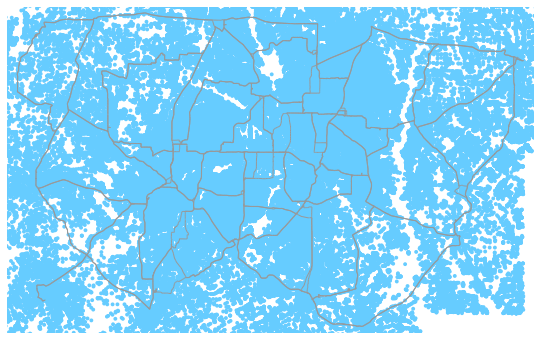

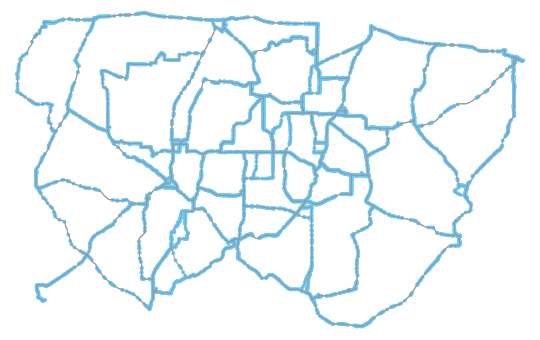

(<Figure size 829.055x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc91bc44d30>)

In [35]:
Simple = nx.DiGraph()
for ix, path in CClusterShortestPath.items():
    nx.add_path(Simple,path)

for ix, node in Simple.nodes.items():
    node['x']=G.nodes[ix]['x']
    node['y']=G.nodes[ix]['y']

Gsimple=G.copy()
edgeslist=list(Gsimple.edges())

for i in edgeslist:
    if not Simple.has_edge(i[0],i[1]):
        Gsimple.remove_edge(i[0],i[1])
ox.plot_graph(Gsimple)
        
Gsimpler=Gsimple.copy()

nodeslist=list(Gsimpler.nodes())
for i in nodeslist:
    if not Simple.has_node(i):
        Gsimpler.remove_node(i)


ox.plot_graph(Gsimpler)

In [36]:
CClusterPathLength=np.zeros([nclusters,nclusters])

for i, path in CClusterShortestPath.items():
    for j in range(len(path)-1):
        CClusterPathLength[i[0]][i[1]]=CClusterPathLength[i[0]][i[1]]+Gsimpler[path[j]][path[j+1]][0]['length']

CClusterAvgSpeed=np.zeros([nclusters,nclusters])
    
for i in CClusterShortestPath.keys():
    CClusterAvgSpeed[i[0]][i[1]]=CClusterPathLength[i[0]][i[1]]/CClusterTravelTime[i[0]][i[1]]*3.6

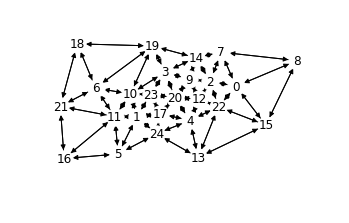

In [37]:
SourcesGraph = nx.DiGraph()

energy_stepsize = battery_size / C # how much energy (in kWh) at each discretization step
energy_per_m = battery_size / vehicle_range # battery size of chevy bolt / range of chevy bolt

stepsize_per_MWh=1000./energy_stepsize #energy_stepsize is in kWh
MWh_per_stepsize=1./stepsize_per_MWh
charge_req_matrix = np.zeros([nclusters,nclusters])
for i in range(nclusters):
    for j in range(nclusters):
        charge_req_matrix[i][j]=np.round(CClusterPathLength[i][j] * energy_per_m / energy_stepsize)

#Add one edge wherever we have a direct link
#Attributes: TravelTime, Length, Capacity
for i, path in CClusterShortestPath.items():
    SourcesGraph.add_edge(i[0],i[1])
    SourcesGraph[i[0]][i[1]]['traveltime']=CClusterTravelTime[i[0]][i[1]]
    SourcesGraph[i[0]][i[1]]['length']=CClusterPathLength[i[0]][i[1]]
    SourcesGraph[i[0]][i[1]]['capacity']=CClusterCapacity[i[0]][i[1]]
    SourcesGraph[i[0]][i[1]]['charge_req'] = charge_req_matrix[i[0]][i[1]]
    
    
nodepos={}
nodelabel={}
for nodeid in SourcesGraph.nodes():
    nodelabel[nodeid]=str(nodeid)
for nodex, node in SourcesGraph.nodes.items():
    node['x']=G.nodes[clusters[nodex]['node']]['x']
    node['y']=G.nodes[clusters[nodex]['node']]['y']
    nodepos[nodex]=[node['x'],node['y']]

Austin_ax=ctboundaries.plot(alpha=0.0,linewidth=0)
nodelabels={}

nx.draw(SourcesGraph,nodepos,ax=Austin_ax,node_alpha=0.1,node_color='w',labels=nodelabel,arrows=1)
if plot_flag is True:
    plt.savefig(figure_data_dir+'ClusteredTractGraph.png',bbox_inches='tight',transparent=True)

outputnp = open(road_data_dir+'SourcesGraph_'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(SourcesGraph, outputnp)
outputnp.close()
#print len(SourcesGraph.nodes())

In [38]:
# Prepare node positions for MATLAB
nodepos_vec=np.zeros([len(nodepos),2])
for k in nodepos.keys():
    nodepos_vec[k,:]=nodepos[k]

In [39]:
outputc = open(road_data_dir+'SourcesGraph_'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(SourcesGraph, outputc)
outputc.close()
outputc = open(road_data_dir+'NodePos_'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(nodepos, outputc)
outputc.close()

# Format for MATLAB

In [40]:
SimpleIncidence=nx.incidence_matrix(SourcesGraph, oriented=True)
sources = [cluster['node'] for name, cluster in clusters.items()]

#roadgraph
adjacencies = np.zeros((len(SourcesGraph.nodes()),), dtype=np.object)
nodelist = sorted(list(SourcesGraph.nodes()))
for i,source in enumerate(nodelist):
    adjacencies[i] = []
    if len(SourcesGraph[source].keys()) ==0:
        print(source)
    for target in SourcesGraph[source].keys():
        target = nodelist.index(target)
        adjacencies[i] += [target + 1] #the +1 is to make it compatible to matlab like indexing
    

In [41]:
# store the ids of the tracts, and the index in the nodelist

# get new nn model
node_coords = np.array([ [ SourcesGraph.nodes[n]['x'], SourcesGraph.nodes[n]['y']]for n in SourcesGraph.nodes()])
nbrs = NearestNeighbors(n_neighbors=1).fit(node_coords)
distances, indices = nbrs.kneighbors(kmeans.cluster_centers_)

# build the arrays
cluster_names = []
cluster_indices = []
for i,cluster in enumerate(kmeans.cluster_centers_):
    cluster_names.append(i)
    #cluster_indices.append(indices[i][0] + 1) # +1 for matlab
    cluster_indices.append(indices[i][0])

In [42]:
census_names = []
census_clusters = []
for name, tract in census_tracts.items():
    census_names.append(tract['name'])
    census_clusters.append(tract['cluster'])


In [43]:
cap_matrix = CClusterCapacity
# build travel time matrix
time_matrix = CClusterTravelTime
# Already aptly named charge_req_matrix
dist_matrix = CClusterPathLength

# Power Network

In [44]:
substations = pd.read_excel(power_data_dir+'Texas2000_June2016.xlsx', sheet_name=1)
buses = pd.read_excel(power_data_dir+'Texas2000_June2016.xlsx', sheet_name=2)
lines = pd.read_excel(power_data_dir+'Texas2000_June2016.xlsx', sheet_name=3)
loads = pd.read_excel(power_data_dir+'Texas2000_June2016.xlsx', sheet_name=5)
generators = pd.read_excel(power_data_dir+'Texas2000_June2016.xlsx', sheet_name=6)
transformers = pd.read_excel(power_data_dir+'Texas2000_June2016.xlsx', sheet_name=4)

baseMVA = 100.


In [45]:
lines = lines.append(transformers, ignore_index=True, sort=True)

In [46]:
def find_nominal_kV(line):
    if np.isnan(line['From Bus Nominal Kv']):
        
        return buses['Nominal kV'][line['From Bus Number']-1]
    else:
        return line['From Bus Nominal Kv']

nomkV=lines.apply(find_nominal_kV,axis=1)
lines['Nominal kV']=nomkV

def find_reactance(line):
    return (line['Nominal kV']**2/baseMVA)*line['X, pu']

reactOhm=lines.apply(find_reactance,axis=1)

lines['Reactance, Ohm']=reactOhm

In [47]:
# build the PowerGraph
power_graph = np.zeros((len(buses),), dtype=np.object)
for i,bus in buses.iterrows():
    power_graph[i] = list(lines[lines['From Bus Number'] == bus['Bus Number']]['To Bus Number']) # from-t


In [48]:
# Create a NetworkX data structure.
Gpower=nx.MultiDiGraph()
for i,bus in buses.iterrows():
    Gpower.add_node(bus['Bus Number'],gen=False,MW=0)
    Gpower.nodes[bus['Bus Number']]['Substation Number']=bus['Substation Number']
for i,bus in buses.iterrows():
    linkslist= lines[lines['From Bus Number'] == bus['Bus Number']]
    for line in linkslist.iterrows():
        Gpower.add_edge(line[1]['From Bus Number'],line[1]['To Bus Number'],
                        MVA_Limit=line[1]['MVA Limit']/baseMVA,  X_pu=line[1]['X, pu'])
        

for nodeix,nodedata in Gpower.nodes.items():
    sub_nr = nodedata['Substation Number']
    nodedata['lon'] = substations[substations['Substation Number'] == sub_nr]['Longitude'].iloc[0]
    nodedata['lat'] = substations[substations['Substation Number'] == sub_nr]['Latitude'].iloc[0]

In [49]:
generators_info = pd.read_excel(power_data_dir+'power_generators.xlsx')

In [50]:
# build the power generators
power_gen = generators['Bus Number']

# generator capacity
power_genmax = generators['Max MW']
power_genmin = generators['Min MW']

# both lists are in the same order
generators['type'] = generators_info[u'Power source']

In [51]:
# This is also a great source: https://www.bv.com/docs/reports-studies/nrel-cost-report.pdf
# cost of energy in $/MWh
# source EIA, “Levelized cost and levelized avoided cost of new generation resources in the annual energy outlook 2017,”
#    U.S. Energy Information Administration, Tech. Rep., 2017.
discounted_cost_by_source = {
    "Wind": 73.6,
    "Nuclear": 95.2,
    "Natural gas": 75.2,
    "Oil": 75.2, # not sure
    "Hydro": 70.,
#    "Gas": 75.2,
    "Biomass": 100.5,
    "Coal": 95.1,
    "Solar": 125.3,
#    "Natural Gas":75.2,
}

#Source EIA: Table 8.4. Average Power Plant Operating Expenses for Major U.S. Investor-Owned Electric Utilities, 2006 through 2016 (Mills per Kilowatthour)
# https://www.eia.gov/electricity/annual/html/epa_08_04.html

operational_cost_by_source_2010 = {
    "Wind": 0,
    "Nuclear": 23.98,
    "Natural gas": 48.74,
    "Oil": 35.76, 
    "Hydro": 9.15,
    "Biomass": 0,
    "Coal": 35.76,
    "Solar": 0,
}

operational_cost_by_source_2016 = {
    "Wind": 0,
    "Nuclear": 25.36,
    "Natural gas": 30.19,
    "Oil": 36.08,
    "Hydro": 10.98,
    "Biomass": 0,
    "Coal": 36.08,
    "Solar": 0,
}

costs = {
    'discounted': discounted_cost_by_source,
    'operational_2010': operational_cost_by_source_2010,
    'operational_2016': operational_cost_by_source_2016
}

cost_by_source = costs[power_cost_type]

In [52]:
gtypes = np.zeros(len(generators), dtype=np.object)
costs = np.zeros(len(generators), dtype=np.float64)

for i,row in generators_info.iterrows():
    gtypes[i] = row['Power source']
    costs[i] = cost_by_source[row['Power source']]

generators['type'] = gtypes
generators['cost'] = costs

In [53]:
# Add generator data to the graph
for genix,gendata in generators.iterrows():
    #print gen[1]
    Gpower.nodes[gendata['Bus Number']]['gen']=True
    Gpower.nodes[gendata['Bus Number']]['Min MW']=gendata['Min MW']
    Gpower.nodes[gendata['Bus Number']]['Max MW']=gendata['Max MW']
    Gpower.nodes[gendata['Bus Number']]['type']=gendata['type']
    Gpower.nodes[gendata['Bus Number']]['cost']=gendata['cost']

In [54]:
# Emissions by type of power plant. Unit is g/kWh

# Load table
Emissions_by_source = pd.read_excel(emissions_data_dir+'/042418_plantEmissionData.xlsx')

Emissions_by_source = Emissions_by_source.set_index('Plant type')
#print Emissions_by_source.index
# Careful about capitalization and oil->fuel oil
#
#print Emissions_by_source.loc['natural gas']
NoEmissionsFrame = pd.DataFrame([["-", "-", "-", 0,0,0,0,0,0,0,"g/kWh"]],columns = Emissions_by_source.columns,index=['NonPollutant'])
NoEmissionsFrame
Emissions_by_source = Emissions_by_source.append(NoEmissionsFrame)
Emissions_by_source
# Pack

,Database,Name in database,Geographical scope,CO2/carbon dioxide,CO/carbon monoxide,CH4/methane,NOx/nitrogen oxides - NOx as NO2,Particulates,SO2/sulfur dioxide,VOCs (NMVOC+VOC),unit
natural gas,ecoinvent,"Electricity, natural gas, at power plant/US",US,594.0,0.4310,3.410000,0.367,0.020250,5.79000,0.187610,g/kWh
NaN,USLCI,"Electricity, natural gas, at power plant/US",US,634.0,0.4900,3.328000,0.581,0.046590,5.70000,0.214340,g/kWh
natural gas cogen,ecoinvent,"Electricity, at cogen 1MWe lean burn, allocati...",Europe,499.0,0.9060,2.940000,0.989,0.003612,0.17200,0.056819,g/kWh
coal,ecoinvent,"Electricity, hard coal, at power plant/US",US,1130.0,0.2570,1.450000,2.390,1.204200,5.24000,0.096071,g/kWh
NaN,USLCI,"Electricity, bituminous coal, at power plant/US",US,1030.0,0.2970,1.832500,3.070,0.779100,6.87000,0.064800,g/kWh
fuel oil,USLCI,"Electricity, residual fuel oil, at power plant/US",US,904.0,3.7400,1.181400,1.790,0.161600,2.41500,0.532000,g/kWh
fuel oil cogen,no data available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diesel,USLCI,"Electricity, diesel, at power plant/RNA",North America,1090.0,4.3700,1.361500,1.940,0.161000,0.51600,0.661200,g/kWh
diesel cogen,ecoinvent,"Electricity, at cogen 200kWe diesel SCR, alloc...",Switzerland,681.0,1.2700,0.793000,0.925,0.064840,0.94300,0.748000,g/kWh
biomass,USLCI,"Electricity, biomass, at power plant/US",US,42.8,0.0851,0.007911,0.679,0.038803,0.00115,0.588000,g/kWh


In [55]:
#  Social cost from EASIUR: http://barney.ce.cmu.edu/~jinhyok/easiur/publications/
#generators.loc[genix]['lon']=1
generators.loc[genix]

def get_bus_lonlat(bus_index):
    return (Gpower.nodes[bus_index]['lon'],Gpower.nodes[bus_index]['lat'])

get_bus_lonlat(generators.loc[0]['Bus Number'])
genlonlats = map(get_bus_lonlat,generators['Bus Number'])
genlon, genlat = zip(*genlonlats)
generators['Lon'] = genlon
generators['Lat'] = genlat
#genlonlats
with open(emissions_data_dir+'genlonlats.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for genlonlat in genlonlats:
        spamwriter.writerow(genlonlat)
# Since we are lazy, we used the data from the EASIUR website. Dollar year: 2010. Income and population year: 2016 
# Costs are in $/metric ton

Emissions_by_location = pd.read_csv(emissions_data_dir+'easiur_genlonlats.csv')
Emissions_by_location.columns

Index(['Longitude', 'Latitude', 'x', 'y', 'PM25 Annual Ground',
       'PM25 Winter Ground', 'PM25 Spring Ground', 'PM25 Summer Ground',
       'PM25 Fall Ground', 'SO2 Annual Ground', 'SO2 Winter Ground',
       'SO2 Spring Ground', 'SO2 Summer Ground', 'SO2 Fall Ground',
       'NOX Annual Ground', 'NOX Winter Ground', 'NOX Spring Ground',
       'NOX Summer Ground', 'NOX Fall Ground', 'NH3 Annual Ground',
       'NH3 Winter Ground', 'NH3 Spring Ground', 'NH3 Summer Ground',
       'NH3 Fall Ground', 'PM25 Annual 150m', 'PM25 Winter 150m',
       'PM25 Spring 150m', 'PM25 Summer 150m', 'PM25 Fall 150m',
       'SO2 Annual 150m', 'SO2 Winter 150m', 'SO2 Spring 150m',
       'SO2 Summer 150m', 'SO2 Fall 150m', 'NOX Annual 150m',
       'NOX Winter 150m', 'NOX Spring 150m', 'NOX Summer 150m',
       'NOX Fall 150m', 'NH3 Annual 150m', 'NH3 Winter 150m',
       'NH3 Spring 150m', 'NH3 Summer 150m', 'NH3 Fall 150m',
       'PM25 Annual 300m', 'PM25 Winter 300m', 'PM25 Spring 300m',
      

In [56]:
TypeGenToTypeEmissions = {
    "Wind": "NonPollutant",
    "Nuclear": "NonPollutant",
    "Natural gas": "natural gas",
    "Oil": "fuel oil",
    "Hydro": "NonPollutant",
    "Biomass": "biomass",
    "Coal": "coal",
    "Solar": "NonPollutant",
}
def SocialCostByGenerator(genid):
    Generator_emissions = Emissions_by_source.loc[TypeGenToTypeEmissions[generators.loc[genid]['type']]]
    CO2_emissions = Generator_emissions['CO2/carbon dioxide']
    CO_emissions = Generator_emissions['CO/carbon monoxide']
    CH4_emissions = Generator_emissions['CH4/methane']
    NOx_emissions = Generator_emissions['NOx/nitrogen oxides - NOx as NO2']
    PM_emissions = Generator_emissions['Particulates']
    SO2_emissions = Generator_emissions['SO2/sulfur dioxide']
    VOC_emissions  = Generator_emissions['VOCs (NMVOC+VOC)']
    NH3_emissions = 0. #We do not have this data.
    
    CO2_cost = 105. #https://19january2017snapshot.epa.gov/climatechange/social-cost-carbon_.html
    CO_cost = 0. #COME BACK TO THIS
    CH4_cost = 2800. #same as above
    NOx_cost = Emissions_by_location.loc[genid]['NOX Annual Ground']
    PM_cost = Emissions_by_location.loc[genid]['PM25 Annual Ground']
    SO2_cost = Emissions_by_location.loc[genid]['SO2 Annual Ground']
    VOC_cost = 0. # No data for this one
    NH3_cost = Emissions_by_location.loc[genid]['NH3 Annual Ground']
    
    SocialCost = CO2_emissions*CO2_cost + CO_emissions*CO_cost + CH4_emissions*CH4_cost + NOx_emissions*NOx_cost + PM_emissions*PM_cost + SO2_emissions*SO2_cost + VOC_emissions*VOC_cost + NH3_emissions*NH3_cost
    SocialCost = SocialCost/1000. # Emissions are in g/kWh, or kg/MWh. Costs are in $/ton. By dividing by 1000. we convert costs to $/kg and thus social cost to $/MWh.
    return SocialCost
    
generators['Social cost'] = list(map(SocialCostByGenerator,generators.index))
generators['Social cost']

0        0.000000
1      198.573594
2      198.573594
3      198.573594
4      198.573594
          ...    
277      0.000000
278      0.000000
279    123.200817
280      0.000000
281      0.000000
Name: Social cost, Length: 282, dtype: float64

In [57]:
# external loads
ext_loads = np.zeros(len(buses), dtype=np.float64)
for i,load in loads.iterrows():
    ext_loads[ int(load['Bus Number'] - 1) ] = load['MW']
    Gpower.nodes[load['Bus Number']]['MW'] = load['MW']

In [58]:
# add latlon to the buses outside the graph
bus_lats = np.zeros(len(buses))
bus_lons = np.zeros(len(buses))

for i,bus in buses.iterrows():
    sub_nr = bus['Substation Number']
    bus_lons[i] = substations[substations['Substation Number'] == sub_nr]['Longitude'].iloc[0]
    bus_lats[i] = substations[substations['Substation Number'] == sub_nr]['Latitude'].iloc[0]

buses['lat'] = bus_lats
buses['lon'] = bus_lons

In [59]:
bus_coords = np.concatenate((bus_lons[:,None], bus_lats[:,None]), axis=1)

In [60]:
#Filter networkx graph
filterpgflag=0

if filterpgflag:
    nodestoremove=[]
    donotremove=[]
    for nodeid, nodedata in Gpower.node.iteritems():
    #    print [nodedata['lon'],nodedata['lat']]
        nodeloc = Point([nodedata['lon'],nodedata['lat']])
        remove=1
        for ctid, ct in ctboundaries.iterrows():
            if nodeloc.within(ct.geometry):
                remove=0
        if remove==1:
            nodestoremove.append(nodeid)
        else:
            donotremove.append(nodeid)
    #donotremove
    Gpower.remove_nodes_from(nodestoremove)
    DisconnectedPNodes=[]
    for ndid, ndval in Gpower.node.iteritems():
        if Gpower.in_degree()[ndid]+Gpower.out_degree()[ndid] ==0:
            DisconnectedPNodes.append(ndid)
    Gpower.remove_nodes_from(DisconnectedPNodes)

<class 'matplotlib.axes._subplots.AxesSubplot'>


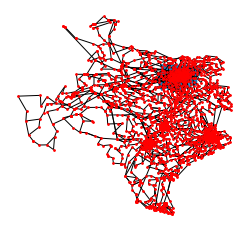

In [61]:
#Extract link information from networkx
power_graph_full = np.zeros((len(buses),), dtype=np.object)
power_MVA_full = np.zeros((len(buses),), dtype=np.object)
power_react_full = np.zeros((len(buses),), dtype=np.object)

power_graph_fullNX = np.zeros((len(Gpower),), dtype=np.object)
power_MVA_fullNX = np.zeros((len(Gpower),), dtype=np.object)
power_react_fullNX = np.zeros((len(Gpower),), dtype=np.object)

for i,bus in buses.iterrows():
    power_graph_full[i] = list()
    power_MVA_full[i]=list()
    power_react_full[i]=list()
for i in range(len(Gpower)):
    power_graph_fullNX[i] = list()
    power_MVA_fullNX[i]=list()
    power_react_fullNX[i]=list()

for i, line in lines.iterrows():
    power_graph_full[np.int(line['From Bus Number'])-1].append(line['To Bus Number'])
    power_MVA_full[np.int(line['From Bus Number'])-1].append(line['MVA Limit']/baseMVA)
    power_react_full[np.int(line['From Bus Number'])-1].append(line['X, pu'])

# Let's number the nodes, since we assume they are numbered 1...len(G) in MATLAB

PowerNodeMap={}

ndid=1; #the +1 is for MATLAB
for nd in Gpower.nodes():
    PowerNodeMap[nd]=float(ndid)
    ndid+=1
    
# for eid, edgeval in Gpower.edge.iteritems():
#     #if eid>2:
#     #    break
#     #print 'Start', eid
#     #print edgeval
#     for e2id, e2val in edgeval.iteritems():
#         #print 'End', e2id
#         #print e2val 
#         for peid, peval in e2val.iteritems():
#             #print 'Parallel', peid
#             #print peval
#             power_graph_fullNX[int(PowerNodeMap[eid])-1].append(PowerNodeMap[e2id])
#             power_MVA_fullNX[int(PowerNodeMap[eid])-1].append(peval['MVA_Limit'])
#             power_react_fullNX[int(PowerNodeMap[eid])-1].append(peval['X_pu'])
            
for eid, e2id in Gpower.edges():
    for peid, peval in Gpower[eid][e2id].items():
        power_graph_fullNX[int(PowerNodeMap[eid])-1].append(PowerNodeMap[e2id])
        power_MVA_fullNX[int(PowerNodeMap[eid])-1].append(peval['MVA_Limit'])
        power_react_fullNX[int(PowerNodeMap[eid])-1].append(peval['X_pu'])
            
pnodepos_plot={}
pnodepos_NX=np.zeros([len(Gpower),2])
for nodeix,nodedata in Gpower.nodes.items():
    pnodepos_plot[nodeix]=[nodedata['lon'],nodedata['lat']]
    pnodepos_NX[int(PowerNodeMap[nodeix])-1,...]=np.array([nodedata['lon'],nodedata['lat']])

Austin_ax=ctboundaries.plot()

nx.draw(Gpower,pnodepos_plot,node_size=3, node_color='r',ax=Austin_ax,arrows=False)
#ctboundaries.plot(ax=Austin_ax)
print(type(Austin_ax))
#print type(aa2)


In [62]:
outputGe = open(power_data_dir+'TXGenerators_v2.pkl', 'wb')
pickle.dump(generators,outputGe)
outputGe.close()

generators
outputG = open(power_data_dir+'Gpower_'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(Gpower, outputG)
outputG.close()


outputPNP = open(power_data_dir+'Pnodepos_'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(pnodepos_plot, outputPNP)
outputPNP.close()

In [63]:
# Extract generator information from networkx
ext_loadsNX = np.zeros(len(Gpower), dtype=np.float64)
for i,load in loads.iterrows():
    ext_loads[ int(load['Bus Number'] - 1) ] = load['MW']

GensListNX=[]
GensMaxNX=[]
GensMinNX=[]
GensCostNX=[]
for nix, ndata in Gpower.nodes.items():
    ext_loadsNX[int(PowerNodeMap[nix])-1]=ndata['MW']
    if ndata['gen']:
        GensListNX.append(PowerNodeMap[nix])
        GensMaxNX.append(ndata['Max MW'])
        GensMinNX.append(ndata['Min MW'])
        GensCostNX.append(ndata['cost'])


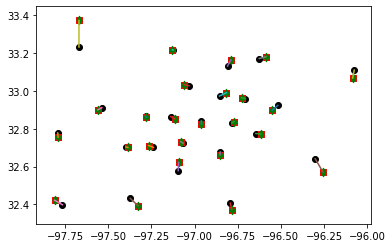

In [64]:
# road to power map
#Everything with a NX suffix refers to the networkx data.

# the list of chargers are simply the OD clusters
charger_list = cluster_indices

# the RoadToPowerMap
# everything is zero, except where there is a cluster, at which point choose nearest substation
road_to_power_map = np.zeros(len(nodelist),dtype=np.int)
road_to_power_mapNX = np.zeros(len(nodelist),dtype=np.int)
power_nbrs  = NearestNeighbors(n_neighbors=1).fit(bus_coords)
power_nbrsNX  = NearestNeighbors(n_neighbors=1).fit(pnodepos_NX)

for road_ind in cluster_indices:
    #print road_ind
    node = SourcesGraph.nodes[nodelist[road_ind]] #the -1 is because cluster_indices is in MATLAB format
    distances, indices = power_nbrs.kneighbors(np.array([[node['x'], node['y']]]))
    road_to_power_map[road_ind] = indices[0][0] + 1 # for matlab
    distancesNX, indicesNX = power_nbrsNX.kneighbors(np.array([[node['x'], node['y']]]))
    road_to_power_mapNX[road_ind] = indicesNX[0][0] + 1 # for matlab
    
#G.node[152567815]['x']
clusters[1]['node']

for ix, cluster in clusters.items():
    plt.scatter(G.nodes[cluster['node']]['x'],G.nodes[cluster['node']]['y'],marker='o',color='k')
    plt.plot([G.nodes[cluster['node']]['x'],bus_coords[road_to_power_map[ix]-1][0]],[G.nodes[cluster['node']]['y'],bus_coords[road_to_power_map[ix]-1][1]])

for chg in road_to_power_map:
    plt.scatter(bus_coords[chg - 1][0],bus_coords[chg - 1][1],marker='s',color='r')
    
for chg in road_to_power_mapNX:
    plt.scatter(pnodepos_NX[chg - 1][0],pnodepos_NX[chg - 1][1],marker='d',color='g')

In [65]:
# power to road map
power_to_road_map = np.zeros(len(buses),dtype=np.int)
power_to_road_mapNX = np.zeros(len(Gpower),dtype=np.int)

for road_ind in charger_list:
    pwr_ind = road_to_power_map[road_ind]
    power_to_road_map[int(pwr_ind) - 1] = road_ind + 1#the +1 is for MATLAB
    pwr_indNX = road_to_power_mapNX[road_ind]
    power_to_road_mapNX[int(pwr_indNX) - 1] = road_ind + 1#the +1 is for MATLAB

There are 252.0  load nodes in the DFW area
There are 25.0  chargers


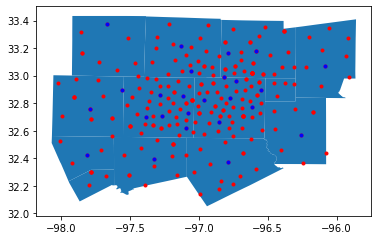

In [66]:
# Label power network nodes located inside the DFW region for further exploration later

isbusinDallas = np.zeros([bus_coords.shape[0]])

for bus_id in range(bus_coords.shape[0]):
    busloc = Point(bus_coords[bus_id])
    for ctid, ct in ctboundaries.iterrows():
        if busloc.within(ct.geometry):
            isbusinDallas[bus_id]=1    
print('There are', sum(isbusinDallas), ' load nodes in the DFW area')
isbusinDallas=isbusinDallas>0

bus_coords_DFW=bus_coords[isbusinDallas,:]
Austin_ax=ctboundaries.plot()
plt.plot(bus_coords_DFW[:,0],bus_coords_DFW[:,1],'.r')


isbusaCharger = np.zeros([bus_coords.shape[0]])


for chg in road_to_power_map:
    isbusaCharger[chg-1]=1
print('There are', sum(isbusaCharger), ' chargers')
isbusaCharger=isbusaCharger>0

bus_coords_Chargers=bus_coords[isbusaCharger,:]
plt.plot(bus_coords_Chargers[:,0],bus_coords_Chargers[:,1],'.b')

In [67]:
outputD = open(power_data_dir+'isbusinDallas'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(isbusinDallas, outputD)
outputD.close()

outputC = open(power_data_dir+'isbusaCharger'+str(nclusters)+'_v2.pkl', 'wb')
pickle.dump(isbusaCharger, outputC)
outputC.close()

In [68]:
sio.savemat(scenario_dir+'dfw_buslocations_'+str(nclusters)+'cl_windsun_v3.mat',{
        'isbusinDallas': isbusinDallas,
        'isbusaCharger':isbusaCharger
    })

## Get load tract flows

### Departure time:
  - 2016: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_5YR_B08302&prodType=table
  - 2010: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_10_5YR_B08302&prodType=table


### Means of transportation to work:
  - 2016: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_5YR_S0802&prodType=table
  - 2010: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_10_5YR_S0802&prodType=table


### Aggregate number of vehicles: 
  - 2016: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_5YR_B08015&prodType=table
  - 2010: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_10_5YR_B08015&prodType=table

In [69]:
census_flows = pd.read_csv(commute_data_dir+'DFW_area_tract_flows.csv',low_memory=False)
census_timesF = pd.read_csv(commute_data_dir+'ACS_10_5YR_B08302/ACS_10_5YR_B08302_with_ann.csv')
census_modeF  = pd.read_csv(commute_data_dir+'ACS_10_5YR_S0802/ACS_10_5YR_S0802_with_ann.csv')
census_num_vehiclesF = pd.read_csv(commute_data_dir+'ACS_10_5YR_B08015/ACS_10_5YR_B08015_with_ann.csv')

/home/frossi/miniconda3/envs/amodenv3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,219,220,221,222,223,224,225,226,299,300,301,302,303,304,305,306,331,332,333,334,335,336,337,338,555,556,557,558,559,560,561,562,723,724,725,726,727,728,729,730) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [70]:
def get_res_geoID(_row):
    return int(_row['Residence_State_FIPS_Code']*1e9 + _row['Residence_County_FIPS_Code']*1e6 + _row['Residence_Tract_FIPS_Code'])

def get_wp_geoID(_row):
    return int(_row['Workplace_State_FIPS_Code']*1e9 + _row['Workplace_County_FIPS_Code']*1e6 + _row['Workplace_Tract_FIPS_Code'])

census_flows['Residence_Tract_GEOId'] = census_flows.apply(get_res_geoID,axis=1)
census_flows['Workplace_Tract_GEOId'] = census_flows.apply(get_wp_geoID,axis=1)

In [71]:
# NEW
census_num_vehicles=census_num_vehiclesF[[u'GEO.id2',u'HD01_VD01']]
census_num_vehicles=census_num_vehicles[1:]
census_num_vehicles['GEO.id2'] = census_num_vehicles['GEO.id2'].apply(int)
census_num_vehicles.set_index(u'GEO.id2',inplace=True)

In [72]:
myyear =2018
mymonth = 1
myday = 1

In [73]:
#01: total, 02: car alone, 03: carpooled, 04: public transit
# EST
# VC99 through VC108: see sample_times_mode

my_columns =[u'GEO.id2']
#Totals
for mymode in ['01','02','03','04']:
    my_columns.append('HC'+mymode+'_EST_VC01')
#By departure time
for mytime in range(99,109):
    for mymode in ['01','02','03','04']:
        my_columns.append('HC'+mymode+'_EST_VC'+str(mytime))

census_mode=census_modeF[my_columns]
        
sample_times_mode = [pd.datetime(myyear,mymonth,myday,0,0),
pd.datetime(myyear,mymonth,myday,5,0),
pd.datetime(myyear,mymonth,myday,5,30),
pd.datetime(myyear,mymonth,myday,6,0),
pd.datetime(myyear,mymonth,myday,6,30),
pd.datetime(myyear,mymonth,myday,7,0),
pd.datetime(myyear,mymonth,myday,7,30),
pd.datetime(myyear,mymonth,myday,8,0),
pd.datetime(myyear,mymonth,myday,8,30),
pd.datetime(myyear,mymonth,myday,9,0)]

census_mode=census_mode[1:]
census_mode.replace(to_replace='-', value='0.', inplace=True)
census_mode[u'GEO.id2']=census_mode[u'GEO.id2'].apply(int)
census_mode.set_index(u'GEO.id2',inplace=True)
for col in census_mode.columns:
    census_mode[col]=census_mode[col].apply(float)


#The mode split is a PERCENTAGE...


In [74]:
census_flows_by_residence = census_flows.groupby('Residence_Tract_GEOId').sum()['EST']
census_flows_by_residence
def compute_frac_dep(_row):
    return float(_row['EST'])/float(census_flows_by_residence[_row['Residence_Tract_GEOId']])
census_flows['Fraction']=census_flows.apply(compute_frac_dep,axis=1)

In [75]:
# Census dep times


sample_times = [pd.datetime(myyear,mymonth,myday,0,0),
pd.datetime(myyear,mymonth,myday,5,0),
pd.datetime(myyear,mymonth,myday,5,30),
pd.datetime(myyear,mymonth,myday,6,0),
pd.datetime(myyear,mymonth,myday,6,30),
pd.datetime(myyear,mymonth,myday,7,0),
pd.datetime(myyear,mymonth,myday,7,30),
pd.datetime(myyear,mymonth,myday,8,0),
pd.datetime(myyear,mymonth,myday,8,30),
pd.datetime(myyear,mymonth,myday,9,0),
pd.datetime(myyear,mymonth,myday,10,0),
pd.datetime(myyear,mymonth,myday,11,0),
pd.datetime(myyear,mymonth,myday,12,0),
pd.datetime(myyear,mymonth,myday,16,0)]

sample_times_col = [u'GEO.id', u'GEO.id2', u'GEO.display-label','Total','MoE Total']
for st in sample_times:
    sample_times_col.append(st)
    sample_times_col.append('MoE '+str(st))
census_timesF.columns = sample_times_col
sample_times2=list(sample_times)
sample_times2.append( u'GEO.id2')

In [76]:
census_times=census_timesF[sample_times2]
census_times=census_times[1:] #Drop metatada in first row
census_times[u'GEO.id2']=census_times[u'GEO.id2'].apply(int)
census_times=census_times.set_index(u'GEO.id2')

In [77]:
def make_series_int(_row):
    return _row.apply(int)

census_times=census_times.apply(make_series_int,axis=1)

In [78]:
def get_node_from_tract(tractid):
    cluster_ind = census_clusters[census_names.index(tractid)]
    return cluster_indices[cluster_ind]

In [79]:
def get_source_node(series):
    return get_node_from_tract(series['Residence_Tract_GEOId'])

def get_target_node(series):
    return get_node_from_tract(series['Workplace_Tract_GEOId'])

In [80]:
census_flows['source'] = census_flows.apply(get_source_node, axis=1)
census_flows['target'] = census_flows.apply(get_target_node, axis=1)

In [81]:
# # Time-varying departure times

avg_carpool_occupancy = 1  #Just replace carpools with private cars

# Resample departure times
departure_times = pd.date_range(start=pd.datetime(myyear,mymonth,myday,StartHour,0,0),end=pd.datetime(myyear,mymonth,myday,EndHourPax,0,0),freq=str(stepsize)+'s')
# Compute bucket length
sample_times_mode_closed = sample_times_mode[:]
sample_times_mode_closed.append(pd.datetime(myyear,mymonth,myday+1,0,0,0))
bucket_length_dt = np.array(sample_times_mode_closed[1:])-np.array(sample_times_mode_closed[:-1])
bucket_length = list(map(lambda x: x.seconds, bucket_length_dt))

# Where do we leave from?
origin_tract_set = set(census_flows['Residence_Tract_GEOId'])

# Prepare an empty object to save distribution of dep times for each tract
origin_tract_times = pd.DataFrame(index=departure_times)

# For each tract, compute the number of people leaving (to any destination) in each time bucket of interest
for origin_tract in origin_tract_set:
    _row = census_mode.loc[origin_tract]
    tot_single_departures = _row['HC02_EST_VC01']
    tot_carpool_departures = _row['HC03_EST_VC01']
    #tot_departures = tot_single_departures + tot_carpool_departures/avg_carpool_occupancy
    #tot_od_flow = tot_departures * record['Fraction']
    #for dep_time in departure_times:
    my_timed_dep = []
    for mytime in range(99,109):
        mydep =  _row['HC02_EST_VC'+str(mytime)]*tot_single_departures + _row['HC03_EST_VC'+str(mytime)]*tot_carpool_departures/avg_carpool_occupancy
        mydep/=100.
        my_timed_dep.append(mydep)
    # Here we compute the frequency, in pax/s, at each location
    my_timed_depframe = pd.DataFrame(np.array(my_timed_dep)/bucket_length,index= sample_times_mode)
    # Here we resample the frequency and then convert to number of pax per user-specified bucket
    my_bucket_deps = my_timed_depframe.reindex(departure_times,method='pad')*stepsize
    my_bucket_deps.columns = [origin_tract]
    # Save
    origin_tract_times=pd.concat([origin_tract_times,my_bucket_deps],axis=1)

In [82]:
origin_tract_times

,48113000500,48113008701,48113008703,48113008704,48113008705,48113016902,48113016903,48121020503,48121020504,48121020505,...,48113000406,48113008603,48113008604,48113016802,48113016803,48113016804,48113012603,48121020401,48121020402,48121020403
2018-01-01 05:00:00,43.7360,67.907000,41.2110,7.7600,99.9020,114.5600,51.195,70.168000,52.0380,89.466000,...,52.135000,18.023000,0.000000,89.364000,97.8660,71.668000,0.000000,137.7980,42.660000,23.511000
2018-01-01 05:30:00,57.6520,0.000000,23.1360,6.9840,0.0000,101.5920,132.030,180.908000,66.6960,132.008000,...,143.110000,0.000000,158.998000,133.319000,32.1480,203.157000,8.305000,200.7960,95.880000,59.469000
2018-01-01 06:00:00,91.4480,68.174000,112.2510,124.9360,72.8640,267.3920,337.710,235.365000,92.2140,201.476000,...,266.302000,143.972000,25.039000,151.531000,854.7840,519.458000,132.880000,210.3060,122.580000,68.519000
2018-01-01 06:30:00,229.7120,90.776000,104.1720,30.2640,11.8680,292.3200,140.160,300.500000,38.1120,292.128000,...,422.833000,68.036000,52.136000,337.579000,188.9280,363.737000,31.710000,180.0240,282.700000,205.347000
2018-01-01 07:00:00,109.3400,69.153000,159.0600,245.8240,65.1360,270.3840,328.950,383.873000,191.6970,453.112000,...,449.131000,143.057000,48.020000,301.714000,435.5280,898.471000,71.725000,242.9260,256.500000,236.493000
2018-01-01 07:30:00,504.9520,57.939000,86.0700,49.6640,44.9880,62.6560,128.190,535.525000,206.7420,433.348000,...,301.909000,0.000000,44.877000,102.249000,167.8860,200.101000,96.303000,337.9860,287.140000,184.737000
2018-01-01 08:00:00,234.9060,77.875000,85.8900,25.2090,17.1120,91.5920,147.210,149.957000,84.9580,472.002000,...,410.340000,59.182000,87.122000,124.568000,201.6000,203.913000,160.815000,262.6210,151.380000,188.177000
2018-01-01 08:30:00,246.5120,21.805000,0.0000,10.0880,24.0120,24.0000,18.330,320.867000,0.0000,204.906000,...,178.935000,20.970000,26.068000,94.780000,39.1680,71.048000,0.000000,101.5810,121.660000,55.320000
2018-01-01 09:00:00,25.9938,7.824833,5.6635,9.0016,1.2026,11.2992,9.576,19.984333,7.6603,30.440333,...,20.612433,2.099467,1.997333,4.829267,18.7368,26.478733,8.500067,29.7844,15.501333,15.431367
2018-01-01 09:30:00,25.9938,7.824833,5.6635,9.0016,1.2026,11.2992,9.576,19.984333,7.6603,30.440333,...,20.612433,2.099467,1.997333,4.829267,18.7368,26.478733,8.500067,29.7844,15.501333,15.431367


In [83]:
# We save the ODT pairs directly by cluster, so as to save time and cycles
workdayslots = int(workdayduration*(3600./float(stepsize)))

# Big matrix
ODT_cluster_flows=np.zeros([nclusters,nclusters,int(ntimesteps)])

ii=0
for ix, record in census_flows.iterrows():
    ii+=1
    if not (ii%1000):
        print(ii,'/',len(census_flows))
    # How many leave from departure location at specified time?
    my_bucket_deps = origin_tract_times[record['Residence_Tract_GEOId']]
    # How many go to given destination
    times_odflows = my_bucket_deps* record['Fraction']
    for _timeslot in range(min(len(origin_tract_times.index),ntimesteps)):
        timestamp = origin_tract_times.index[_timeslot]
        odflow = times_odflows.loc[timestamp]
        
        ODT_cluster_flows[int(record['source']),int(record['target']),_timeslot]+=odflow
        if add_return_trips:
            # For each record, we want to have an inverse record 8 hours later. 1 hour is 3600/stepsize ; 8 hours is int(8.*3600./float(stepsize))
            _returntimeslot = int((_timeslot+workdayslots)%ntimesteps)
            ODT_cluster_flows[int(record['target']),int(record['source']),_returntimeslot]+=odflow

        
# No self loops
for i in range(nclusters):
    for t in range(int(ntimesteps)):
        ODT_cluster_flows[i,i,t]=0
        

1000 / 101141
2000 / 101141
3000 / 101141
4000 / 101141
5000 / 101141
6000 / 101141
7000 / 101141
8000 / 101141
9000 / 101141
10000 / 101141
11000 / 101141
12000 / 101141
13000 / 101141
14000 / 101141
15000 / 101141
16000 / 101141
17000 / 101141
18000 / 101141
19000 / 101141
20000 / 101141
21000 / 101141
22000 / 101141
23000 / 101141
24000 / 101141
25000 / 101141
26000 / 101141
27000 / 101141
28000 / 101141
29000 / 101141
30000 / 101141
31000 / 101141
32000 / 101141
33000 / 101141
34000 / 101141
35000 / 101141
36000 / 101141
37000 / 101141
38000 / 101141
39000 / 101141
40000 / 101141
41000 / 101141
42000 / 101141
43000 / 101141
44000 / 101141
45000 / 101141
46000 / 101141
47000 / 101141
48000 / 101141
49000 / 101141
50000 / 101141
51000 / 101141
52000 / 101141
53000 / 101141
54000 / 101141
55000 / 101141
56000 / 101141
57000 / 101141
58000 / 101141
59000 / 101141
60000 / 101141
61000 / 101141
62000 / 101141
63000 / 101141
64000 / 101141
65000 / 101141
66000 / 101141
67000 / 101141
6800

In [84]:
flow_threshold = 0.01

_sources=np.zeros([sum(sum(sum(ODT_cluster_flows>flow_threshold)))])
_sinks=np.zeros([sum(sum(sum(ODT_cluster_flows>flow_threshold)))])
_deptimes=np.zeros([sum(sum(sum(ODT_cluster_flows>flow_threshold)))])
_flows=np.zeros([sum(sum(sum(ODT_cluster_flows>flow_threshold)))])

iterator=0
for start_cl in range(nclusters):
    #print start_cl,'/',nclusters
    for dest_cl in range(nclusters):
        for dep_time in range(ntimesteps):
            if (ODT_cluster_flows[start_cl,dest_cl,dep_time]>flow_threshold):
                _sources[iterator] = start_cl
                _sinks[iterator]   = dest_cl
                _deptimes[iterator]= dep_time
                _flows[iterator]   = ODT_cluster_flows[start_cl,dest_cl,dep_time]
                iterator+=1

In [85]:
sourceslong=_sources
sinkslong=_sinks
flowslong=_flows
starttimeslong=_deptimes


# Time Varying Model

In [86]:
# time matrix in terms of timesteps
#tv_time_matrix = np.round(time_matrix / stepsize)
tv_time_matrix=np.maximum(np.round(time_matrix / stepsize),time_matrix>0)

In [87]:
#add self-loops
for i in range(len(adjacencies)):
    adjacencies[i] += [i + 1] # the +1 is for MATLAB
    tv_time_matrix[i][i]=1
    cap_matrix[i][i]=np.Inf

In [88]:
# charging speed
charge_speed_per_sec = charge_speed_per_hour / 3600. # 20kwh / 3600 sec
tv_unit_charge_speed = np.ceil((charge_speed_per_sec * stepsize) / energy_stepsize)

# charging times and speeds; array length is that of the chargers
tv_charging_times = np.ones(len(charger_list))
tv_charging_speeds = np.full(len(charger_list), tv_unit_charge_speed)
tv_charger_cap = np.full(len(charger_list),np.inf)

ChargeUnitToEnergyUnit = MWh_per_stepsize/baseMVA # a single unit of C in MVA units (here, 100 MWh). 1C=ChargeUnitToEnergyUnit MWh
ChargeUnitToPowerUnit = ChargeUnitToEnergyUnit*3600./stepsize #This is the resulting power in MW. If we charge c MWh in one timestep, we charge c*3600/timestep MWh in 1h.  

BatteryDepreciationPerUnitCharge = BatteryCost / (BatteryCycles*C)/2.
#BatteryDepreciationPerUnitCharge = 0.

System-wide demand: http://mis.ercot.com/misapp/GetReports.do?reportTypeId=12340&reportTitle=System-Wide%20Demand&showHTMLView=&mimicKey

Weather zones: http://www.ercot.com/content/wcm/lists/143010/2018_Long-Term_Hourly_Peak_Demand_and_Energy_Forecast_Final.pdf, copied by hand in QGIS.

Demand by weather zone: http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13101&reportTitle=Actual%20System%20Load%20by%20Weather%20Zone&showHTMLView=&mimicKey

In [89]:
# If you are here, you are probably thinking that you messed up the units for the conversion from transportation
#  network to power network.
#
# You have not messed up the units. Breathe. Look two cells up for ChargeUnitToPowerUnit. We look at the increase in
#  charge over one time step in MWh through ChargeUnitToEnergyUnit. We then compute the increase in charge per in MWh/h
#  : that is the power required, and ChargeUnitToPowerUnit takes care of that.
#
# Here propagate generator costs and external loads into time
# RDIT: This is a good area for testing changes (i.e. wind energy has min=max and varies with time), loads vary with time, etc

# Generator costs do not change during the day
tv_generator_costs = np.tile(generators['cost'].values[:,None],(1,ntimesteps))
tv_social_generator_costs = np.tile(generators['Social cost'].values[:,None],(1,ntimesteps))


#Costs are in MWh. Here we rescale in MW per timestep
tv_generator_costs = tv_generator_costs*stepsize/3600.
tv_social_generator_costs = tv_social_generator_costs*stepsize/3600.



In [90]:
#tv_ext_loads = np.tile(ext_loads[:,None],(1,ntimesteps))
# Reminder: in the power network, we reason in POWER. So you do need to rescale anything (except for the prices)
# by the length of a timestep

area_name_map = {u'COAST': u'COAST',  u'EAST': u'EAST', u'FWEST': u'FAR_WEST', u'NCENT': u'NORTH_C',
                 u'NORTH': u'NORTH', u'SCENT': u'SOUTH_C', u'SOUTH': u'SOUTHERN', u'WEST': u'WEST'}

# ext_loads is the time-invariant load. We want to rescale it according to the time-varying curve corresponding
#  to the region of each bus

#Unpickle regional loads
input = open(power_data_dir+'renewables/LoadsByRegion.pkl', 'rb')
AvgHourlyLoad = pickle.load(input)
input.close()

# Reindex as datetime, ASSUME it is 00:00-23:00
AvgHourlyLoad_index = pd.date_range(start=pd.datetime(myyear,mymonth,myday,0,0,0),end=pd.datetime(myyear,mymonth,myday,23,0,0),freq='1H')
AvgHourlyLoad.set_index(AvgHourlyLoad_index,inplace=True)

#Normalize. Now we have fractions of baseline per each hour
for col in AvgHourlyLoad:
    AvgHourlyLoad[col] = AvgHourlyLoad[col]/np.mean(AvgHourlyLoad[col])

# Resample according to time
power_times = pd.date_range(start=pd.datetime(myyear,mymonth,myday,StartHour,0,0),end=pd.datetime(myyear,mymonth,myday+int((StartHour+nhours)/24),(StartHour+nhours)%24,0,0),freq=str(stepsize)+'s')
power_times = power_times[:-1]
AvgHourlyLoadSampled=AvgHourlyLoad.reindex(power_times,method='pad')
# Remember, these are instantaneous powers. So you do not need to rescale by bin length!

tv_ext_loads=np.ndarray([len(buses),ntimesteps])
for _bus in range(len(buses)):
    if not _bus%100:
        print(_bus, '/', len(buses))
    for _t in range(ntimesteps):
        tv_ext_loads[_bus,_t] = ext_loads[_bus] * AvgHourlyLoadSampled.loc[power_times[_t]][area_name_map[buses.loc[_bus]['Area Name']]]


0 / 2007
100 / 2007
200 / 2007
300 / 2007
400 / 2007
500 / 2007
600 / 2007
700 / 2007
800 / 2007
900 / 2007
1000 / 2007
1100 / 2007
1200 / 2007
1300 / 2007
1400 / 2007
1500 / 2007
1600 / 2007
1700 / 2007
1800 / 2007
1900 / 2007
2000 / 2007


In [91]:
print (tv_ext_loads.shape)

tv_gensmax = np.tile(generators['Max MW'].values[:,None],(1,ntimesteps))
tv_gensmin = np.tile(generators['Min MW'].values[:,None],(1,ntimesteps))



(2007, 24)


## Base generation is minimally throttlable


In [92]:
generators_base=generators.copy()

# %for it, genitem in generators_base.iterrows():
#     if genitem['type']=='Nuclear' or genitem['type']=='Coal':
#         genitem['Max MW']=genitem['MW dispatch, default']*1.1
#         genitem['Min MW']=genitem['MW dispatch, default']*0.9

tv_gensmax_base = np.tile(generators_base['Max MW'].values[:,None],(1,ntimesteps))
tv_gensmin_base = np.tile(generators_base['Min MW'].values[:,None],(1,ntimesteps))

# Ramp-up and ramp-down constraints

tv_gensrampup_base = 1e6*np.ones([ntimesteps,len(generators_base)])
tv_gensrampup_base = tv_gensrampup_base.astype('float')
tv_gensrampdown_base = 1e6*np.ones([ntimesteps,len(generators_base)])
tv_gensrampdown_base = tv_gensrampdown_base.astype('float')

for it, genitem in generators_base.iterrows():
    if genitem['type']=='Nuclear':
        tv_gensrampup_base[:,it]=.1*stepsize/3600*genitem['Max MW']
        tv_gensrampdown_base[:,it]=.1*stepsize/3600*genitem['Max MW']
    elif genitem['type']=='Coal':
        tv_gensrampup_base[:,it]=.4*stepsize/3600*genitem['Max MW']
        tv_gensrampdown_base[:,it]=.4*stepsize/3600*genitem['Max MW']
    elif genitem['type']=='Wind': #We handle these with fixed output below
        tv_gensrampup_base[:,it]=100.0*genitem['Max MW']*RenewableBoost
        tv_gensrampdown_base[:,it]=100.0*genitem['Max MW']*RenewableBoost
    elif genitem['type']=='Solar':
        tv_gensrampup_base[:,it]=600.0*genitem['Max MW']*RenewableBoost
        tv_gensrampdown_base[:,it]=600.0*genitem['Max MW']*RenewableBoost
    else:
        # Ramp up-down in 10 minutes
        tv_gensrampup_base[:,it]=6.0*genitem['Max MW']
        tv_gensrampdown_base[:,it]=6.0*genitem['Max MW']
#TODO: read wind profile from TexasWindProfile, normalize it so that in average it is 1, apply to generators.
#  Also, reduce throttling capacity of base load nuclear and coal plants.

## Wind and solar generators: constrained to fixed(ish) output

In [93]:
TexasWindProfile=np.load(power_data_dir+'renewables/TexasAvgWindProfile.npy')
TexasWindProfileDF = pd.DataFrame(TexasWindProfile,index=AvgHourlyLoad_index)
# After the next line, the *average* (not sum) TX wind profile is 1. So we capture fluctuations
#  around the mean
TexasWindProfileDF = TexasWindProfileDF/np.mean(TexasWindProfileDF) 
# Recall that these are instantaneous power levels - they average to one if power_times is 
# a uniform grid, they do not sum to one.
TexasWindProfileSampled=TexasWindProfileDF.reindex(power_times,method='pad')

TexasSunProfile=np.load(power_data_dir+'renewables/TexasAvgSunProfile.npy')
TexasSunProfileDF = pd.DataFrame(TexasSunProfile,index=AvgHourlyLoad_index)
TexasSunProfileDF = TexasSunProfileDF/np.mean(TexasSunProfileDF)

TexasSunProfileSampled=TexasSunProfileDF.reindex(power_times,method='pad')

In [94]:
# #Load wind profile from other notebook.
# TexasWindProfile=np.load('TexasAvgWindProfile.npy')
# #Normalize the wind profile so that it is on avg. 1. Then we can use it to rescale the rest
# TexasWindProfile=TexasWindProfile/np.mean(TexasWindProfile)

# LocalWindProfile=np.empty([2*nhours])
# lwpix=0
# for tt in range(StartHour,StartHour+nhours):
#     LocalWindProfile[lwpix:lwpix+2]=TexasWindProfile[tt]
#     lwpix+=2


LocalWindProfile = TexasWindProfileSampled.values[:,0]

    
#print tv_ext_loads.shape
#print ntimesteps
genwind= generators_base[generators_base['type']=='Wind']
for ix, gen in genwind.iterrows():
    tv_gensmin_base[ix]=gen['MW dispatch, default']*LocalWindProfile*0.6
    tv_gensmax_base[ix]=gen['MW dispatch, default']*LocalWindProfile*1.*RenewableBoost
    
LocalSunProfile = TexasSunProfileSampled.values[:,0]

gensolar= generators_base[generators_base['type']=='Solar']
for ix, gen in gensolar.iterrows():
#     tv_gensmin_base[ix]=np.minimum(gen['MW dispatch, default']*LocalSunProfile,gen['Max MW'])
#     tv_gensmax_base[ix]=np.minimum(gen['MW dispatch, default']*LocalSunProfile+0.005,gen['Max MW'])
    tv_gensmin_base[ix]=gen['MW dispatch, default']*LocalSunProfile*0.6
    tv_gensmax_base[ix]=gen['MW dispatch, default']*LocalSunProfile*1.00*RenewableBoost
    # The 0.005 is a ugly hack for feasibility
#     tv_gensmin_base[ix]=np.minimum(tv_gensmin_base[ix],tv_gensmax_base[ix])
#     tv_gensmax_base[ix]=np.maximum(tv_gensmin_base[ix],tv_gensmax_base[ix]+0.05)

## Augment the power network with household solar

In [95]:
# Compute number of roofs per census tract
# Table of households
TX_Households_labeled = pd.read_csv(power_data_dir+'renewables/ACS_10_5YR_DP04/ACS_10_5YR_DP04_with_ann.csv')
TX_Households = TX_Households_labeled[1:]

# Clean up data
TX_Households = TX_Households.replace('-',0)
TX_Households = TX_Households.replace('(X)',0)
TX_Households = TX_Households.replace('**',0)

def compute_roofs(entry):
    return (float(entry['HC01_VC13']) + float(entry['HC01_VC14']) +
            float(entry['HC01_VC15']) / 2. + float(entry['HC01_VC16']) / 3.5 +
            float(entry['HC01_VC17']) / 7 + float(entry['HC01_VC18']) / 14.5 + 
           float(entry['HC03_VC20']))
    # HC01_VC13 + HC01_VC14 + HC01_VC15 / 2 + HC01_VC16 / 3.5 + HC01_VC17 / 7 + HC01_VC18 / 14.5 + HC03_VC20
    # Detatched + Attached  + 2-unit        + 3-4 units       + 5-9 units     +  10-19 units     + mobile home
    
Roofs = TX_Households.apply(compute_roofs,axis=1)
TX_Households['Roofs'] = Roofs

/home/frossi/miniconda3/envs/amodenv3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1,3,4,5,7,8,11,12,23,24,25,27,28,31,32,35,36,39,40,43,44,47,48,51,52,55,56,59,60,63,64,65,67,68,71,72,75,76,79,80,83,84,87,88,91,92,95,96,99,100,103,104,105,107,108,111,112,115,116,119,120,123,124,127,128,131,132,135,136,139,140,147,148,149,151,152,155,156,159,160,163,164,167,168,171,172,175,176,177,179,180,183,184,195,196,197,199,200,203,204,207,208,211,212,215,216,219,220,223,224,225,227,228,231,232,235,236,239,240,243,244,245,247,248,251,252,255,256,259,260,263,264,267,268,271,272,275,276,279,280,283,284,285,287,288,291,292,295,296,299,300,301,303,304,307,308,311,312,315,316,317,319,320,323,324,327,328,331,332,335,336,339,340,343,344,347,348,355,356,357,359,360,363,364,367,368,369,371,372,375,376,379,380,383,384,387,388,391,392,395,396,403,404,405,407,408,411,412,415,416,419,420,423,424,431,432,433,435,436,439,440,443,444,447,448,451,452,455,456,459,460,461

In [96]:
CT_to_substation = {}
geoids_map = []

with fiona.open(power_data_dir+'renewables/Census_tracts_with_substation_labels.shp') as c:
    for f in c:
        tractid = int(f['properties']['GEOID'])
        geoids_map.append(int(tractid))
        substation = int(f['properties']['Substation'])
        CT_to_substation[tractid] = substation

In [97]:
Roofs_per_substation = {}
for subst in CT_to_substation.values():
    Roofs_per_substation[subst] = 0
for tractrow in TX_Households.iterrows():
    tract = tractrow[1]
    gid = int(tract['GEO.id2'])
    subst = CT_to_substation[gid]
    Roofs_per_substation[subst]+=tract['Roofs']

In [98]:
num_solar_substations = len(Roofs_per_substation)
solar_substations = list(Roofs_per_substation.keys())

In [99]:
# We add the solar generators at the end of the power network. We connect them with the
# substation they correspond to with a fat link.
PowerGensList_solarA = range(len(power_graph_full)+1,len(power_graph_full)+num_solar_substations+1)
power_graph_solarA = np.ndarray([num_solar_substations,],dtype=np.object)
power_MVA_solarA = np.ndarray([num_solar_substations,],dtype=np.object)
power_react_solarA = np.ndarray([num_solar_substations,],dtype=np.object)
tv_gensmax_base_solarA = np.zeros([num_solar_substations,ntimesteps],dtype=np.float)
tv_gensmin_base_solarA = np.zeros([num_solar_substations,ntimesteps],dtype=np.float)
tv_generator_costs_solarA = np.zeros([num_solar_substations,ntimesteps],dtype=np.float)
tv_social_generator_costs_solarA = np.zeros([num_solar_substations,ntimesteps],dtype=np.float)
tv_ext_loads_solarA = np.zeros([num_solar_substations,ntimesteps],dtype=np.float)
tv_gensrampup_base_solarA = np.zeros([ntimesteps,num_solar_substations],dtype=np.float)
tv_gensrampdown_base_solarA = np.zeros([ntimesteps,num_solar_substations],dtype=np.float)

min_reactance = min(map(lambda x: min(x) if x else np.NaN, power_react_full))

for subst in range(num_solar_substations):
    power_graph_solarA[subst] = [solar_substations[subst]]
    power_MVA_solarA[subst] = [np.infty]
    power_react_solarA[subst] = [min_reactance]
    tv_gensmax_base_solarA[subst,:] = Roofs_per_substation[solar_substations[subst]]*MW_per_roof*LocalSunProfile
    tv_gensrampup_base_solarA[:,subst] = 600*tv_gensmax_base_solarA[subst,:].T
    tv_gensrampdown_base_solarA[:,subst] = 600*tv_gensmax_base_solarA[subst,:].T
    
power_graph_full_solar = np.concatenate((power_graph_full,power_graph_solarA))
power_MVA_full_solar = np.concatenate((power_MVA_full,power_MVA_solarA))
power_react_full_solar = np.concatenate((power_react_full,power_react_solarA))
PowerGensList_solar = np.concatenate((generators_base['Bus Number'].values,(PowerGensList_solarA)))
tv_gensmax_base_solar = np.concatenate((tv_gensmax_base,tv_gensmax_base_solarA))
tv_gensmin_base_solar = np.concatenate((tv_gensmin_base,tv_gensmin_base_solarA))
tv_generator_costs_solar = np.concatenate((tv_generator_costs,tv_generator_costs_solarA))
tv_social_generator_costs_solar = np.concatenate((tv_social_generator_costs,tv_social_generator_costs_solarA))
tv_ext_loads_solar = np.concatenate((tv_ext_loads,tv_ext_loads_solarA))
tv_gensrampup_base_solar = np.concatenate((tv_gensrampup_base,tv_gensrampup_base_solarA),axis=1)
tv_gensrampdown_base_solar = np.concatenate((tv_gensrampdown_base,tv_gensrampdown_base_solarA),axis=1)


solar_id = np.zeros(tv_gensmax_base.shape)

In [100]:
PowerGensList = generators_base['Bus Number'].values

power_graph_full_bak = power_graph_full.copy()
power_MVA_full_bak = power_MVA_full.copy()
power_react_full_bak = power_react_full.copy()
PowerGensList_bak = PowerGensList.copy()
tv_gensmax_base_bak = tv_gensmax_base.copy()
tv_gensmin_base_bak = tv_gensmin_base.copy()
tv_generator_costs_bak = tv_generator_costs.copy()
tv_social_generator_costs_bak = tv_social_generator_costs.copy()
tv_ext_loads_bak = tv_ext_loads.copy()
tv_gensrampup_base_bak = tv_gensrampup_base.copy()
tv_gensrampdown_base_bak = tv_gensrampdown_base.copy()

In [101]:
if AdditionalSolar:
    solar_gen_id = np.concatenate((np.zeros(tv_gensmax_base.shape),np.ones([num_solar_substations,ntimesteps])))
    power_graph_full = power_graph_full_solar
    power_MVA_full= power_MVA_full_solar
    power_react_full = power_react_full_solar
    PowerGensList = PowerGensList_solar
    tv_gensmax_base = tv_gensmax_base_solar
    tv_gensmin_base = tv_gensmin_base_solar
    tv_generator_costs = tv_generator_costs_solar
    tv_social_generator_costs = tv_social_generator_costs_solar
    tv_ext_loads = tv_ext_loads_solar
    tv_gensrampup_base = tv_gensrampup_base_solar
    tv_gensrampdown_base = tv_gensrampdown_base_solar
else:
    solar_gen_id = np.zeros(tv_gensmax_base.shape)

In [102]:
if AdditionalSolar:
    generators_addsolar = generators.copy()
    generators_addsolar['New Residential Solar'] = False

    generators_newsolar = pd.DataFrame(columns = generators.columns)
    oldgensnumber = len(generators)
    newgensnumber = len(PowerGensList_solar)-oldgensnumber
    generators_newsolar['Bus Number'] = PowerGensList_solar[oldgensnumber:]
    generators_newsolar['Min MW'] = tv_gensmin_base[oldgensnumber:,0]
    generators_newsolar['Max MW'] = tv_gensmax_base[oldgensnumber:,0]
    generators_newsolar['Min Mvar'] = np.NaN*np.ones([newgensnumber,])
    generators_newsolar['Max Mvar'] = np.NaN*np.ones([newgensnumber,])
    generators_newsolar['MW dispatch, default'] = tv_gensmax_base[oldgensnumber:,0]
    generators_newsolar['Voltage Set Point'] = np.NaN*np.ones([newgensnumber,])
    generators_newsolar['type'] = 'Solar'
    generators_newsolar['cost'] = 0
    generators_newsolar['Social cost'] = 0

    newgenslon = np.zeros([newgensnumber,])
    newgenslat = np.zeros([newgensnumber,])
    newbuses = PowerGensList_solar[oldgensnumber:]
    for busid in range(len(newbuses)):
        busgen = newbuses[busid]-1
        busload = power_graph_full_solar[busgen]
        assert(len(busload)==1)
        busload = busload[0]-1

        newgenslon[busid] = bus_coords[busload,0]
        newgenslat[busid] = bus_coords[busload,1]
    generators_newsolar['Lon'] = newgenslon
    generators_newsolar['Lat'] = newgenslat
    generators_newsolar['New Residential Solar'] = True

    generators_addsolar = pd.concat([generators_addsolar,generators_newsolar],ignore_index = True)
    outputGe = open(power_data_dir+'renewables/TXGenerators_addsolar.pkl', 'wb')
    pickle.dump(generators_addsolar,outputGe)
    outputGe.close()


In [103]:
if AdditionalSolar:
    # Label power network nodes located inside the DFW region for further exploration later

    gen_coords_solar = np.array(zip(generators_addsolar['Lon'],generators_addsolar['Lat']))
    #gen_coords_solar = np.array(zip(generators['Lon'],generators['Lat']))
    isGeneratorinDallas_solar = np.zeros([gen_coords_solar.shape[0]])

    for bus_id in range(gen_coords_solar.shape[0]):
        busloc = Point(gen_coords_solar[bus_id])
        for ctid, ct in ctboundaries.iterrows():
            if busloc.within(ct.geometry):
                isGeneratorinDallas_solar[bus_id]=1    
    print ('There are', sum(isGeneratorinDallas_solar), 'generator nodes in the DFW area')
    isGeneratorinDallas_solar=isGeneratorinDallas_solar>0

    gen_coords_DFW_solar=gen_coords_solar[isGeneratorinDallas_solar,:]
    Austin_ax=ctboundaries.plot()
    plt.plot(gen_coords_DFW_solar[:,0],gen_coords_DFW_solar[:,1],'.r')


    #isbusaCharger = np.zeros([bus_coords.shape[0]])


    #for chg in road_to_power_map:
    #    isbusaCharger[chg-1]=1
    #print 'There are', sum(isbusaCharger), ' chargers'
    #isbusaCharger=isbusaCharger>0

    #bus_coords_Chargers=bus_coords[isbusaCharger,:]
    #plt.plot(bus_coords_Chargers[:,0],bus_coords_Chargers[:,1],'.b')

In [104]:
if AdditionalSolar:
    outputD = open(power_data_dir+'renewables/isgeninDallas'+str(nclusters)+'_solar.pkl', 'wb')
    pickle.dump(isGeneratorinDallas_solar, outputD)
    outputD.close()

In [105]:
# If we limit our extra solar to DFW only, we set the renewable generation of out-of-town panels to 0

if LocalSolarOnly and AdditionalSolar:
    for gen_ix, gen in generators_addsolar.iterrows():
#        print gen_ix
        if gen['New Residential Solar'] is True:
#            print gen_ix, 'NRS', isGeneratorinDallas_solar[gen_ix]
            if isGeneratorinDallas_solar[gen_ix] != True:
                tv_gensmax_base[gen_ix] = np.zeros(tv_gensmax_base[gen_ix].shape)
                tv_gensmax_base_solar[gen_ix] = np.zeros(tv_gensmax_base[gen_ix].shape)
            else:
                print ('Solar generator', gen_ix, 'is in DFW')

## Create file for MATLAB solver

In [106]:
MATfilename = scenario_dir+'dfw_roadgraph_tv_'+str(nclusters)+'cl_'+str(nhours)+'h_'+str(stepsize)+'step_returntrips'+str(add_return_trips)+'_'+power_cost_type+'cost'+'.mat'

MATfilename

'scenario/dfw_roadgraph_tv_25cl_12h_1800step_returntripsFalse_operational_2016cost.mat'

In [107]:
sio.savemat(MATfilename,{
        'timeStepSize': stepsize,
        'RoadGraph':adjacencies,
        'RoadCap': csr_matrix(cap_matrix),
        'NodesLonLat': nodepos_vec,
        'RefLonLat': center_coord,
        'TravelTimes': csr_matrix(tv_time_matrix),
        'SimTravelTimes': csr_matrix(time_matrix),
        'TravelDistance' : csr_matrix(dist_matrix),
        'ChargeReqs': csr_matrix(charge_req_matrix),
        'ChargerList': list(map(lambda x: x+1,charger_list)),
        'ChargerSpeeds': tv_charging_speeds,
        'ChargerTimes': tv_charging_times,
        'ChargerCaps': tv_charger_cap,
        'C':float(C),
        'ChargeUnitToPowerUnit': ChargeUnitToPowerUnit,
        'BatteryDepreciationPerUnitCharge': BatteryDepreciationPerUnitCharge,
        'Sources': list(map(lambda x: x+1,sourceslong)),
        'Sinks': list(map(lambda x: x+1,sinkslong)),
        'FlowsIn': flowslong,
        'StartTimes': list(map(lambda x: x+1,starttimeslong)),
        'RoadToPowerMap': road_to_power_map,
        'PowerToRoadMap': power_to_road_map,
        'PowerGraphFull': power_graph_full,
        'PowerLineCapFull': power_MVA_full,
        'PowerLineReactanceFull': power_react_full,
        'PowerGensList': PowerGensList,
        'PowerGensMax': tv_gensmax_base/baseMVA,
        'PowerGensMin': tv_gensmin_base/baseMVA,
        'PowerCosts': tv_generator_costs*baseMVA,
        'PowerSocialCosts': tv_social_generator_costs*baseMVA,
        'PowerExtLoads': tv_ext_loads/baseMVA,
        'ResidentialSolarID': solar_gen_id,
        'Thor': float(ntimesteps),
        'BaseMVA': baseMVA,
        'MinEndCharge': min_end_charge,
        'ValueOfTime': value_of_time,
        'VehicleCostPerKm': vehicle_cost_per_km,
        'v2g_efficiency' : v2g_efficiency,
        'PowerRampUp' : tv_gensrampup_base,
        'PowerRampDown' : tv_gensrampdown_base,
        'num_vehicles' : num_vehicles
    })